# ANALISIS INFLUENCIA DE LOS PARAMETROS DE LA PREPARACIÓN DE LOS DATOS EN LOS MODELOS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import requests
import os
import mlflow
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, confusion_matrix
from preparacion import preparar_datos
import warnings
warnings.filterwarnings('ignore')

No hemos sido capaces de importar los modulos ***descarga_drive*** ni ***evaluar*** asi que los copiamos aqui

In [2]:
def descargar_archivo_directo(id_archivo, directorio_destino, archivo_destino):
    url = f"https://drive.google.com/uc?export=download&id={id_archivo}"
    respuesta = requests.get(url, allow_redirects=True)
    os.makedirs(directorio_destino, exist_ok=True)
    ruta_completa = os.path.join(directorio_destino, archivo_destino)
    with open(ruta_completa, 'wb') as archivo:
        archivo.write(respuesta.content)
    return archivo_destino, ruta_completa

def procesar_archivo_info(ruta_archivo_info):
    archivos_info = []
    with open(ruta_archivo_info, 'r') as archivo:
        for linea in archivo:
            id_archivo, nombre_archivo, directorio_destino = linea.strip().split(',')
            archivos_info.append((id_archivo, nombre_archivo, directorio_destino))
    return archivos_info

def descarga_drive_main(archivos_info):
    dir_act = Path.cwd()
    while not dir_act.name == 'MBA-Finance':
        dir_act = dir_act.parent
    ruta_archivo_info = Path(Path(dir_act, 'archivos'), archivos_info)
    archivos_a_descargar = procesar_archivo_info(ruta_archivo_info)
    for id_archivo, nombre_archivo, directorio_destino in archivos_a_descargar:
        dir_act = Path.cwd()
        while not dir_act.name == 'MBA-Finance':
            dir_act = dir_act.parent
        directorio_destino = Path(dir_act, directorio_destino)
        nombre_archivo_descargado, ruta_archivo_guardado = descargar_archivo_directo(id_archivo, directorio_destino, nombre_archivo)
        print(f"Archivo {nombre_archivo_descargado} guardado en: {ruta_archivo_guardado}")

In [3]:
def cv_selection(n, train_size=.8):
    train_indices = list(range(int(n * train_size)))
    test_indices = list(range(int(n * train_size), n))
    return [(train_indices, test_indices)]
    
def get_tomorrow_rets(df):
    tmrw_rets = df['Rets']
    tmrw_rets.index = df['Date']
    return tmrw_rets.shift(-1)

def score_rendimiento(y, y_pred, **kwargs):
    tmrw_rets = kwargs.get('tomorrow_rets', None).loc[y.index]
    rets = (tmrw_rets + 1).prod()
    strat_rets = ((y_pred * tmrw_rets) + 1).prod()

    if rets == strat_rets or strat_rets == 0:
        return -100
    return strat_rets

def show_plot(y_pred, tomorrow_rets, ax):
    strat = tomorrow_rets * y_pred
    strat_return = ((strat + 1).cumprod() - 1).iloc[-2]
    stock_return = ((tomorrow_rets + 1).cumprod() - 1).iloc[-2]
    print('STOCK RETURN:', stock_return)
    print('STRAT_RETURN:', strat_return)
    ax.plot(tomorrow_rets.index, (tomorrow_rets + 1).cumprod() - 1, label='Stock returns')
    ax.plot(tomorrow_rets.index, (strat + 1).cumprod() - 1, label='Strat returns')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Returns')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

def evaluar(clf, x_train, x_test, y_train, y_test, tomorrow_rets, train_size=.8, show_plots=False, ax_val=None, ax_test=None):
    train_indices, validation_indices = cv_selection(len(x_train), train_size)[0]
    x_t_train, y_t_train = x_train.iloc[train_indices], y_train.iloc[train_indices]
    x_validation, y_validation = x_train.iloc[validation_indices], y_train.iloc[validation_indices]
    clf.fit(x_t_train, y_t_train)
    y_pred_val = clf.predict(x_validation)
    a_v = round(accuracy_score(y_validation, y_pred_val), 5)
    ba_v = round(balanced_accuracy_score(y_validation, y_pred_val), 5)
    re_v = round(recall_score(y_validation, y_pred_val), 5)
    p_v = round(precision_score(y_validation, y_pred_val), 5)
    rs_v = score_rendimiento(y_validation, y_pred_val, tomorrow_rets=tomorrow_rets)
    clf.fit(x_train, y_train)
    y_pred_test = clf.predict(x_test)
    a_t = round(accuracy_score(y_test, y_pred_test), 5)
    ba_t = round(balanced_accuracy_score(y_test, y_pred_test), 5)
    re_t = round(recall_score(y_test, y_pred_test), 5)
    p_t = round(precision_score(y_test, y_pred_test), 5)
    rs_t = score_rendimiento(y_test, y_pred_test, tomorrow_rets=tomorrow_rets)
    print('Matriz de confusión en test:\n', confusion_matrix(y_test, y_pred_test))
    if show_plots:
        show_plot(y_pred_val, tomorrow_rets.loc[y_validation.index], ax_val)
        show_plot(y_pred_test, tomorrow_rets.loc[y_test.index], ax_test)
    return (a_v, ba_v, re_v, p_v, rs_v), (a_t, ba_t, re_t, p_t, rs_t)

def get_clf(archivo, row):
    if 'LR' in archivo:
        return LogisticRegression(C=float(row['C']), penalty=(eval(row['penalty']) if row['penalty'] == 'None' else row['penalty']),
                                  solver=row['solver'], class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
    elif 'RF' in archivo:
        return RandomForestClassifier(n_estimators=int(row['n_estimators']), criterion=row['criterion'], max_depth=int(row['max_depth']),
                                      min_samples_leaf=int(row['min_samples_leaf']), max_features=(row['max_features'] if row['max_features'] == 'sqrt' else int(row['max_features'])),
                                      class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
    elif 'MLP' in archivo:
        return MLPClassifier(hidden_layer_sizes=eval(row['hidden_layer_sizes']), batch_size=int(row['batch_size']), activation=row['activation'],
                             alpha=float(row['alpha']), max_iter=int(row['max_iter']), early_stopping=True, random_state=RANDOM_STATE)

In [4]:
descarga_drive_main('archivos_final.txt')
RANDOM_STATE = 42
symbols = ['AAPL', 'F', 'GOOG', 'META', 'MSFT', 'TSLA']
path_dbs = "./dbs"

Archivo final_AAPL.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_AAPL.parquet
Archivo final_F.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_F.parquet
Archivo final_GOOG.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_GOOG.parquet
Archivo final_META.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_META.parquet
Archivo final_MSFT.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_MSFT.parquet
Archivo final_TSLA.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\final_TSLA.parquet
Archivo datos_final.parquet guardado en: C:\Users\hecto\UNI\2\PDI\MBA-Finance\data\datos_final.parquet


Las gráficas que aparecen en la memoria corresponden a un experimento previo que hicimos, no se utilizan esas bases de datos eneste caso, sino las bases de datos finales.

AAPL
sqlite:///./dbs/LR1.db
#####  LR_AAPL


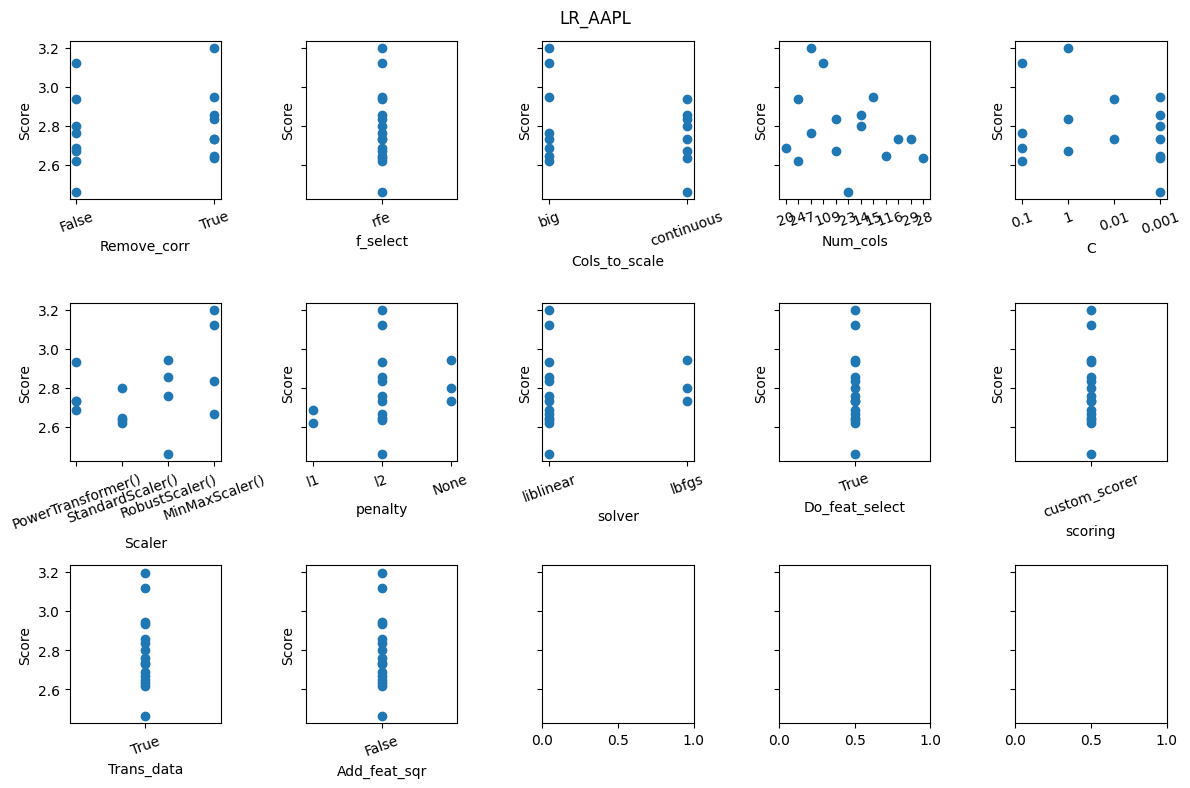

sqlite:///./dbs/MLP1.db
#####  MLP_AAPL


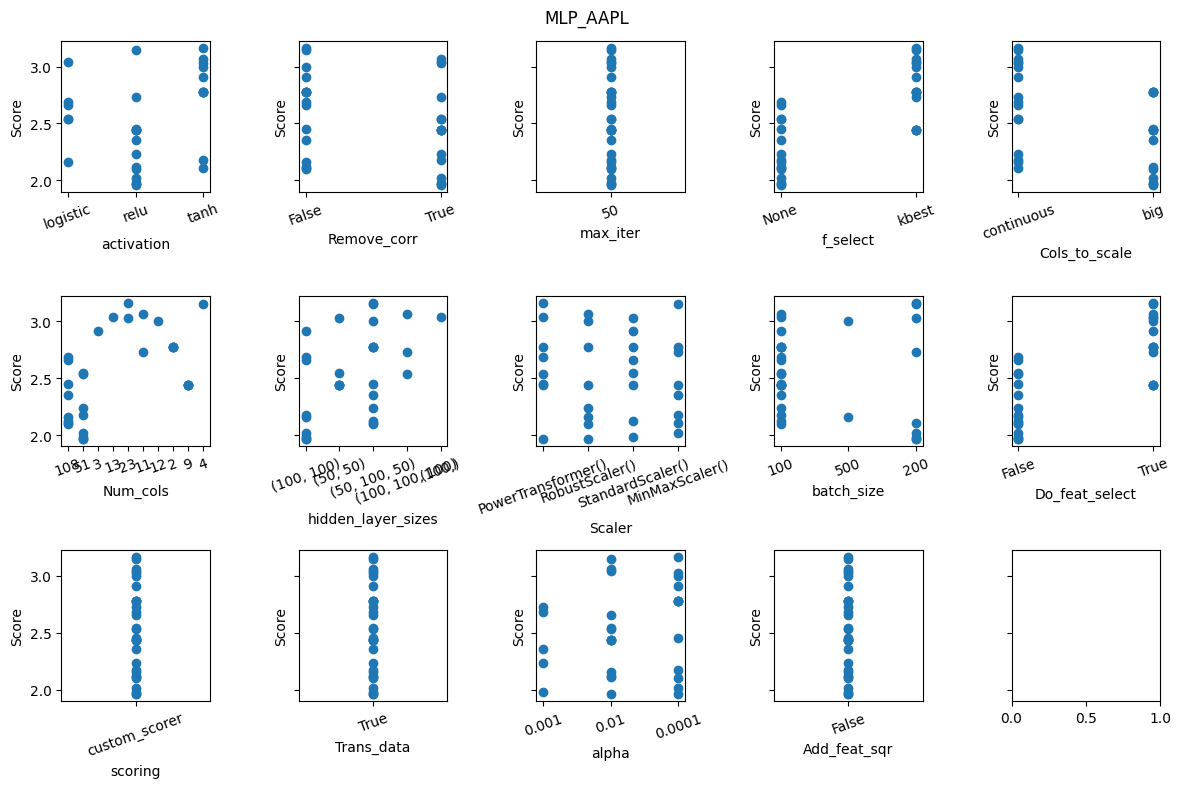

sqlite:///./dbs/RF1.db
#####  RF_AAPL


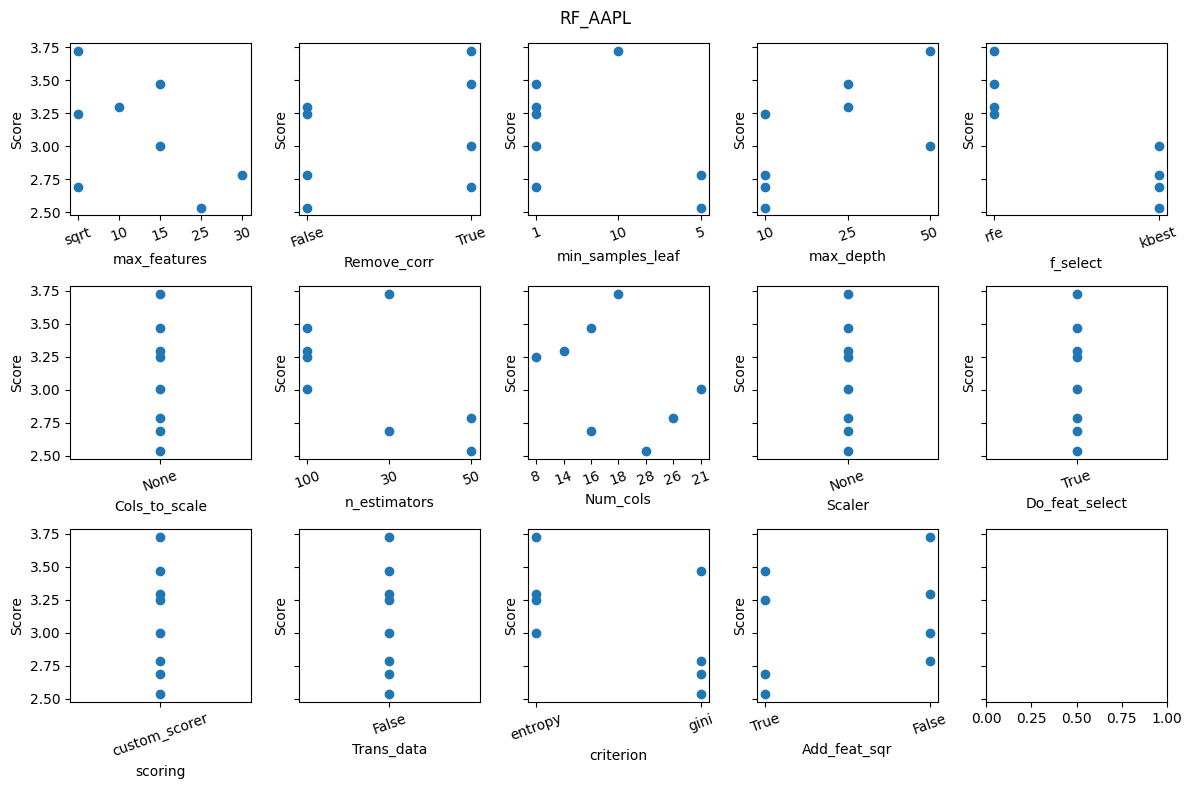

F
sqlite:///./dbs/LR1.db
#####  LR_F


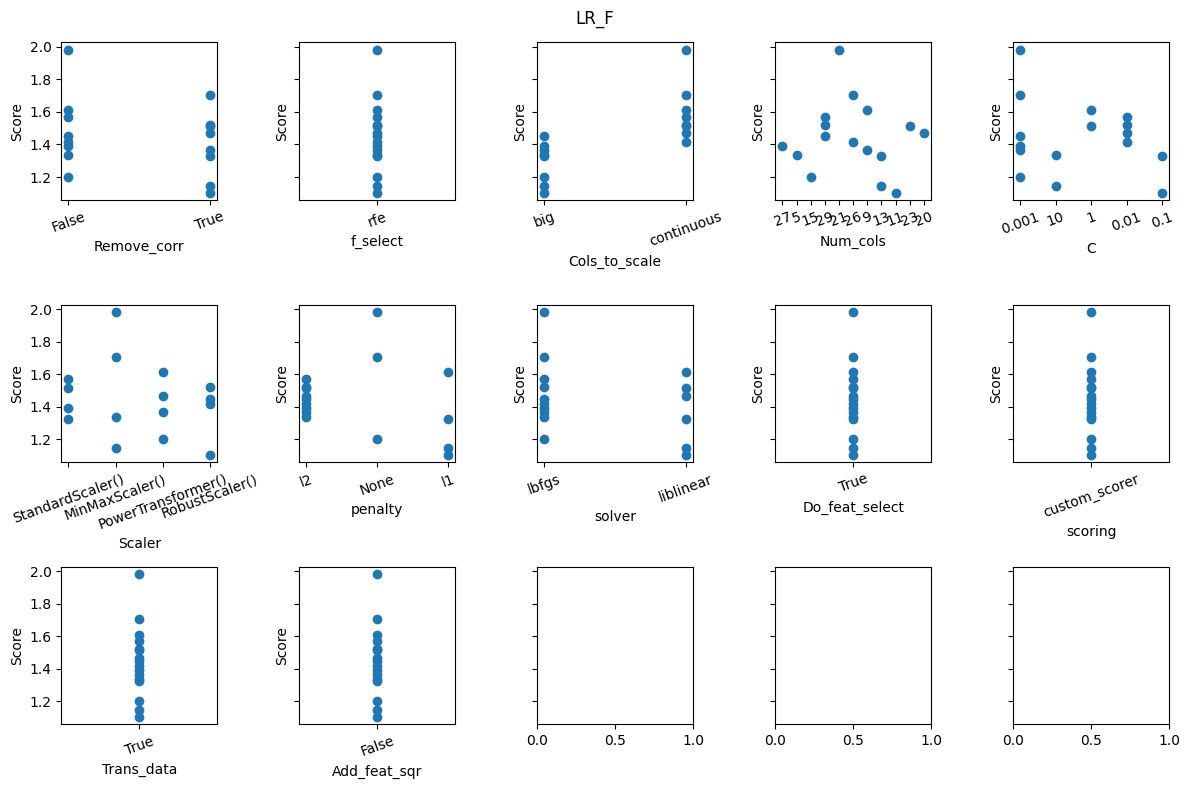

sqlite:///./dbs/MLP1.db
#####  MLP_F


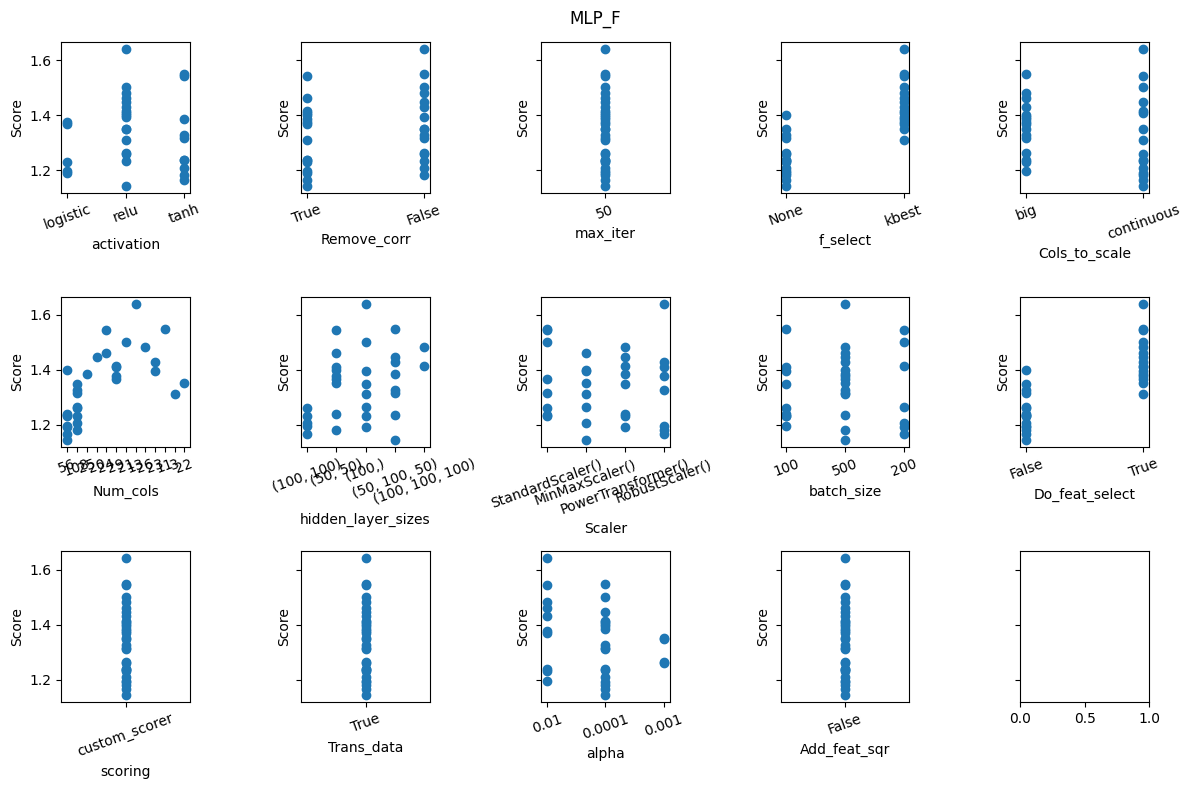

sqlite:///./dbs/RF1.db
#####  RF_F


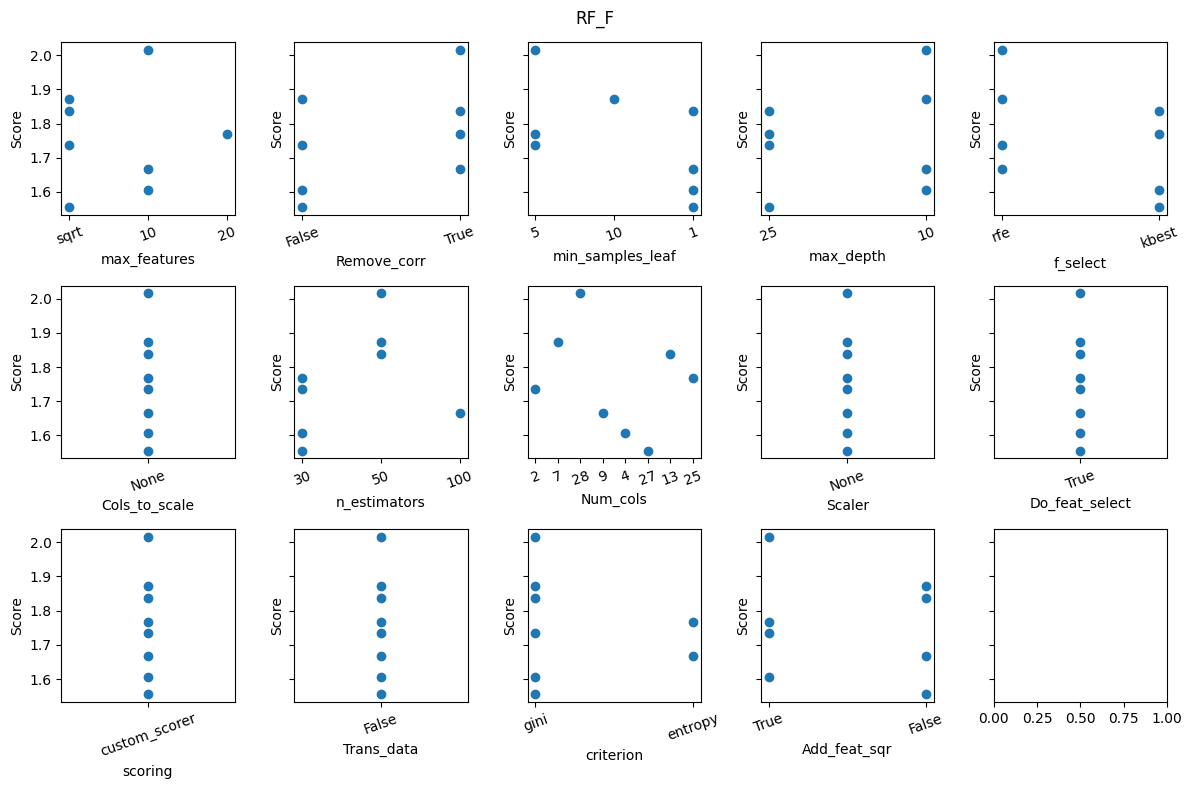

GOOG
sqlite:///./dbs/LR1.db
#####  LR_GOOG


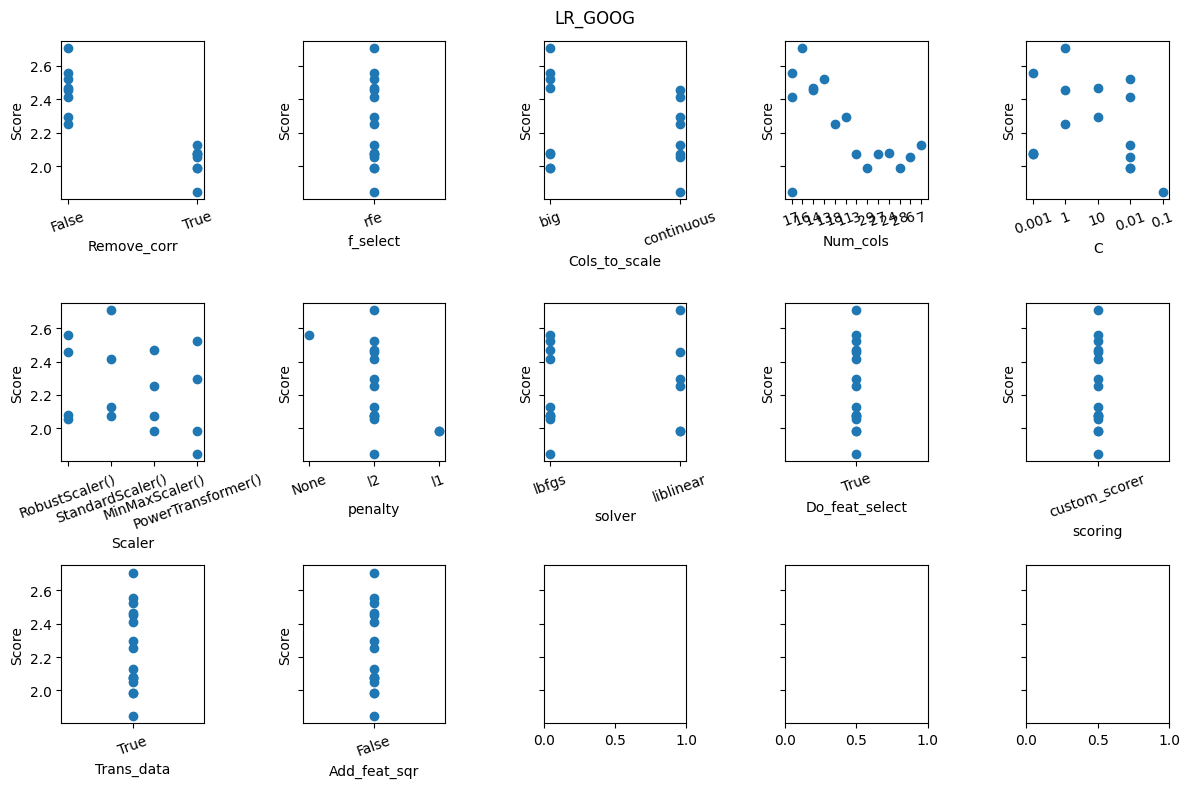

sqlite:///./dbs/MLP1.db
#####  MLP_GOOG


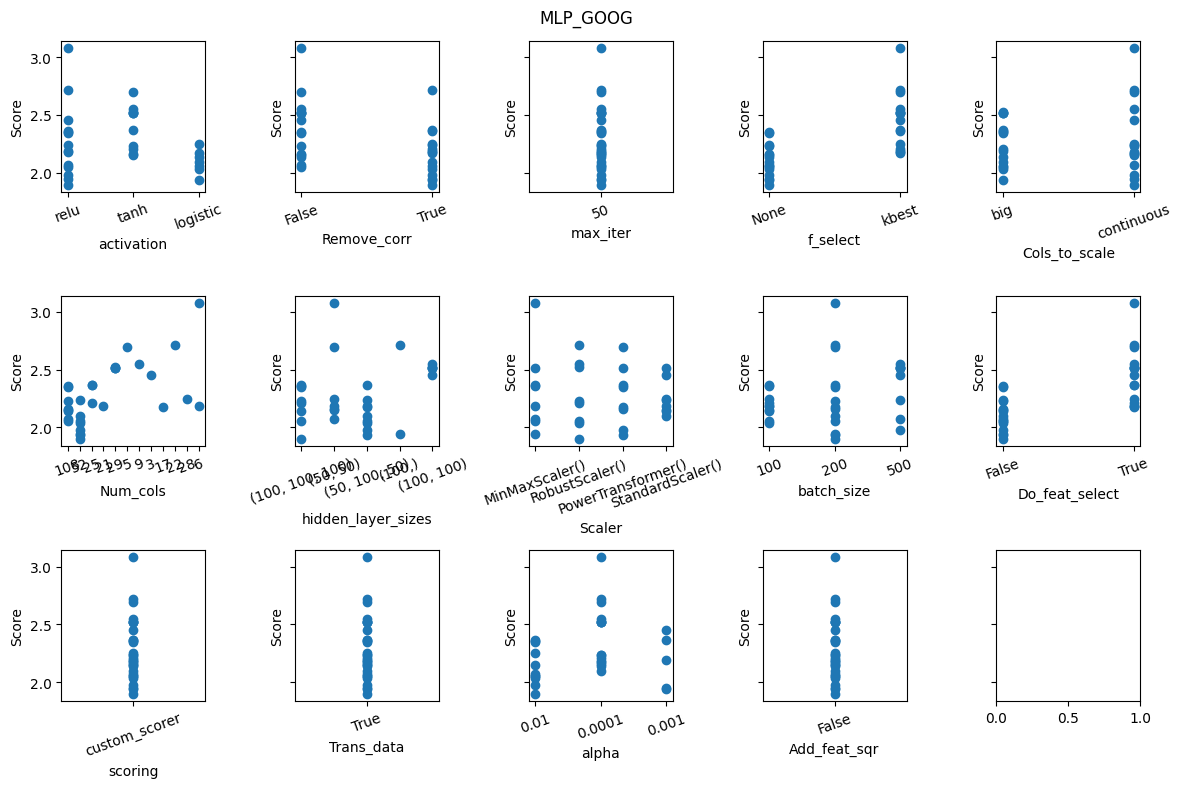

sqlite:///./dbs/RF1.db
#####  RF_GOOG


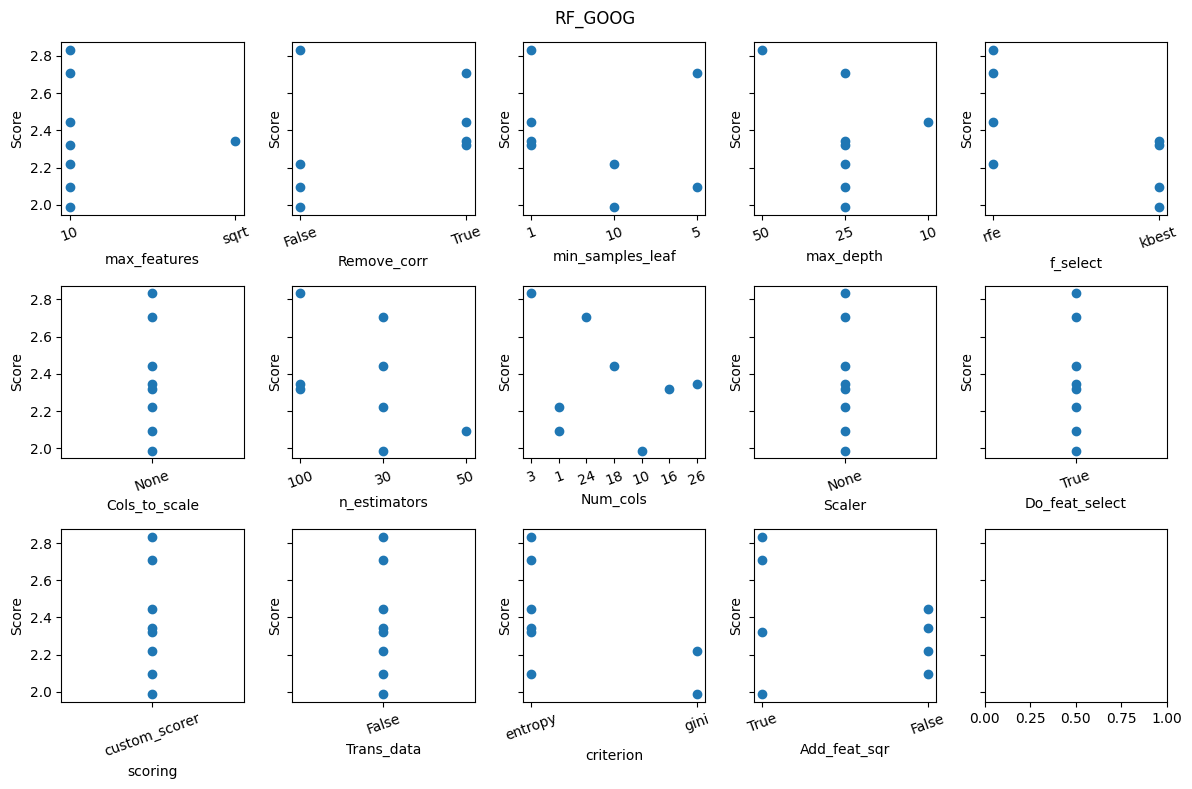

META
sqlite:///./dbs/LR1.db
#####  LR_META


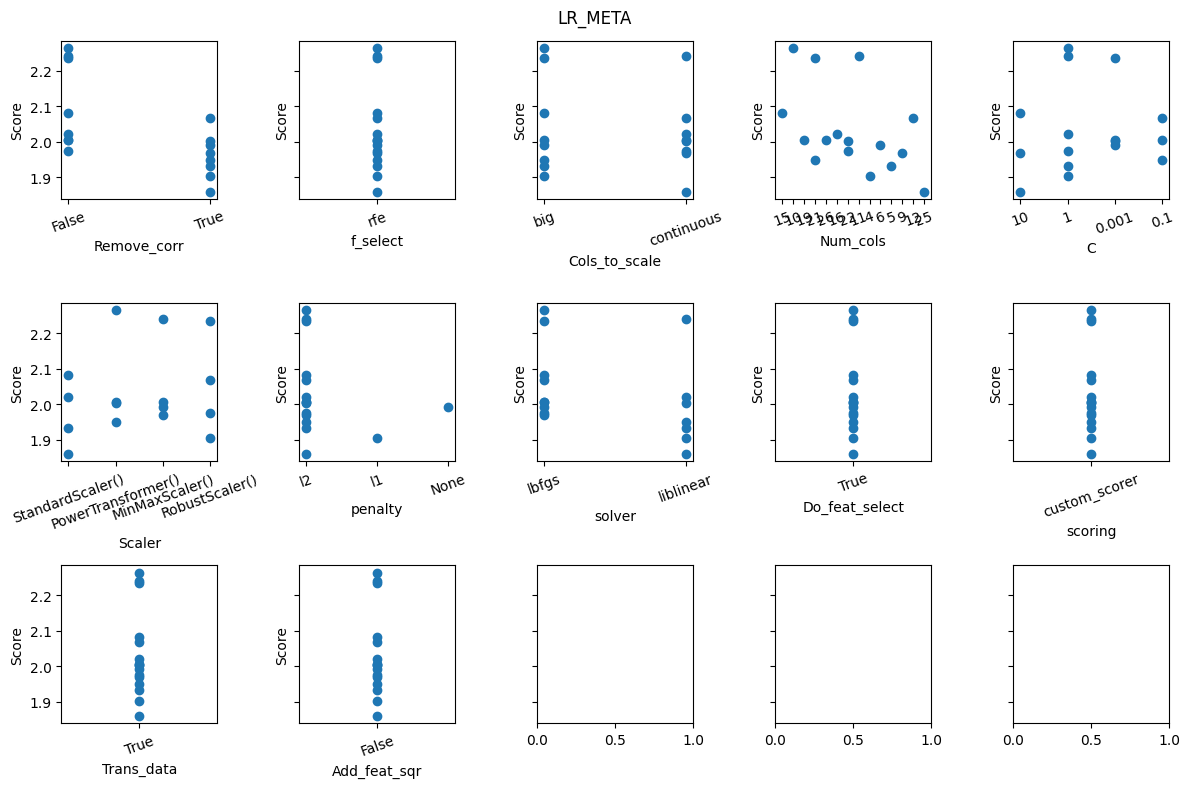

sqlite:///./dbs/MLP1.db
#####  MLP_META


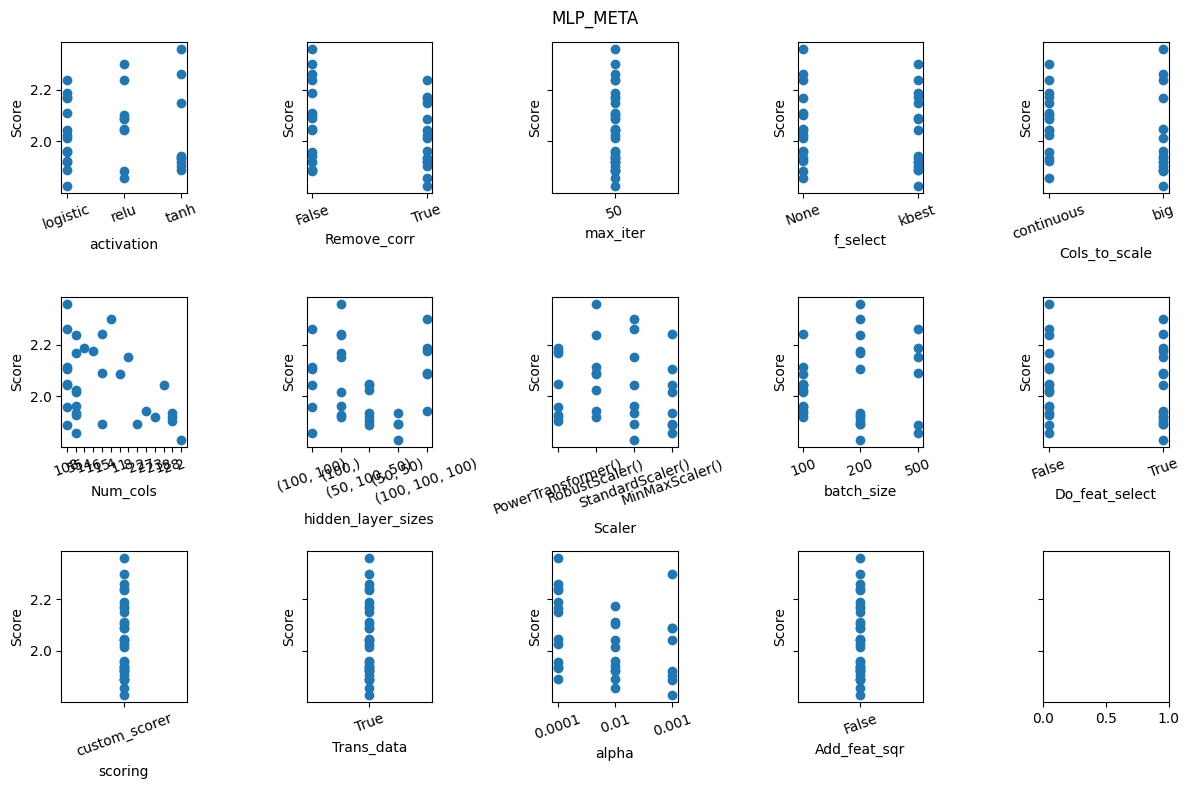

sqlite:///./dbs/RF1.db
#####  RF_META__


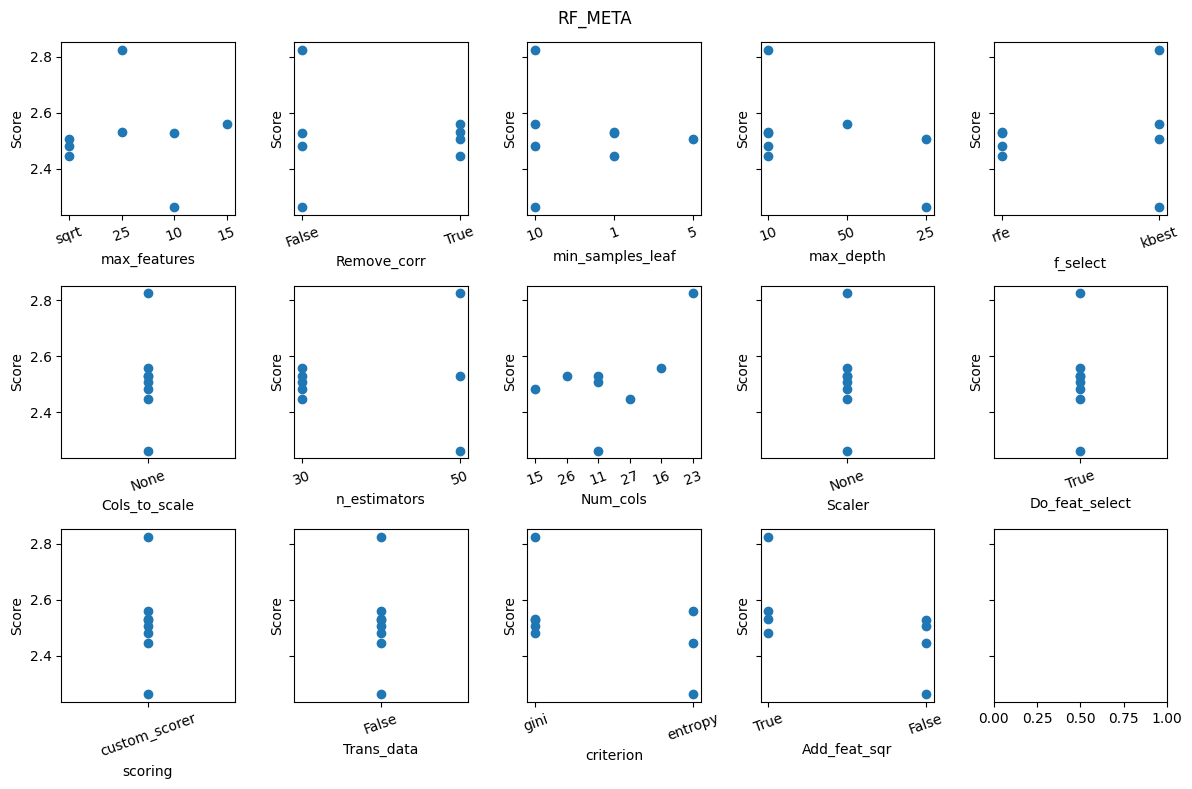

MSFT
sqlite:///./dbs/LR1.db
#####  LR_MSFT


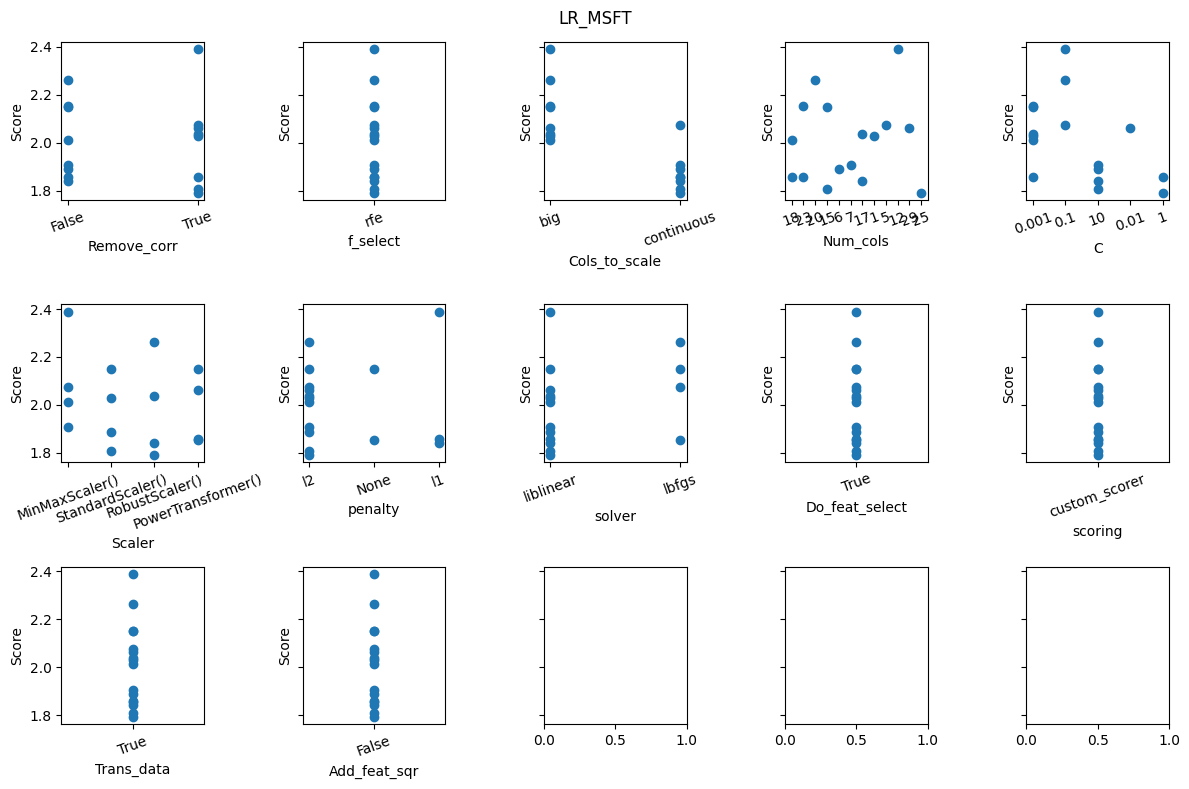

sqlite:///./dbs/MLP1.db
#####  MLP_MSFT


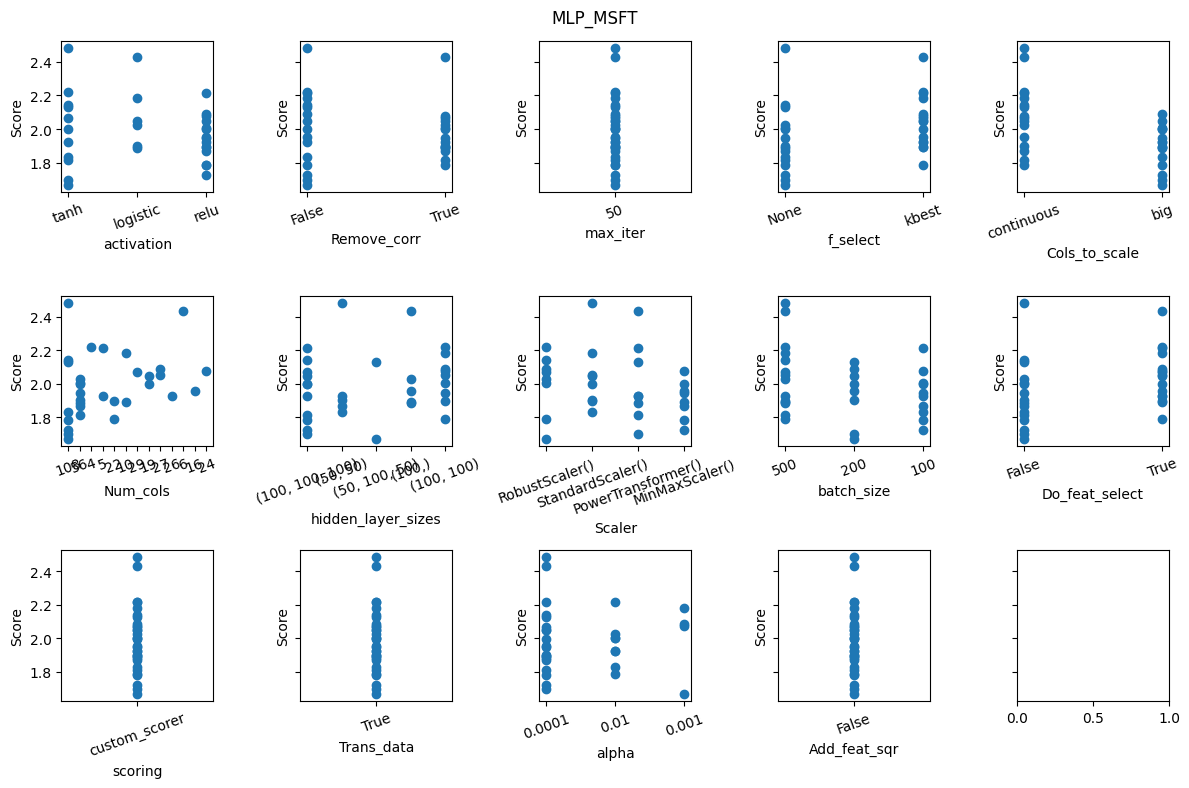

sqlite:///./dbs/RF1.db
#####  RF_MSFT


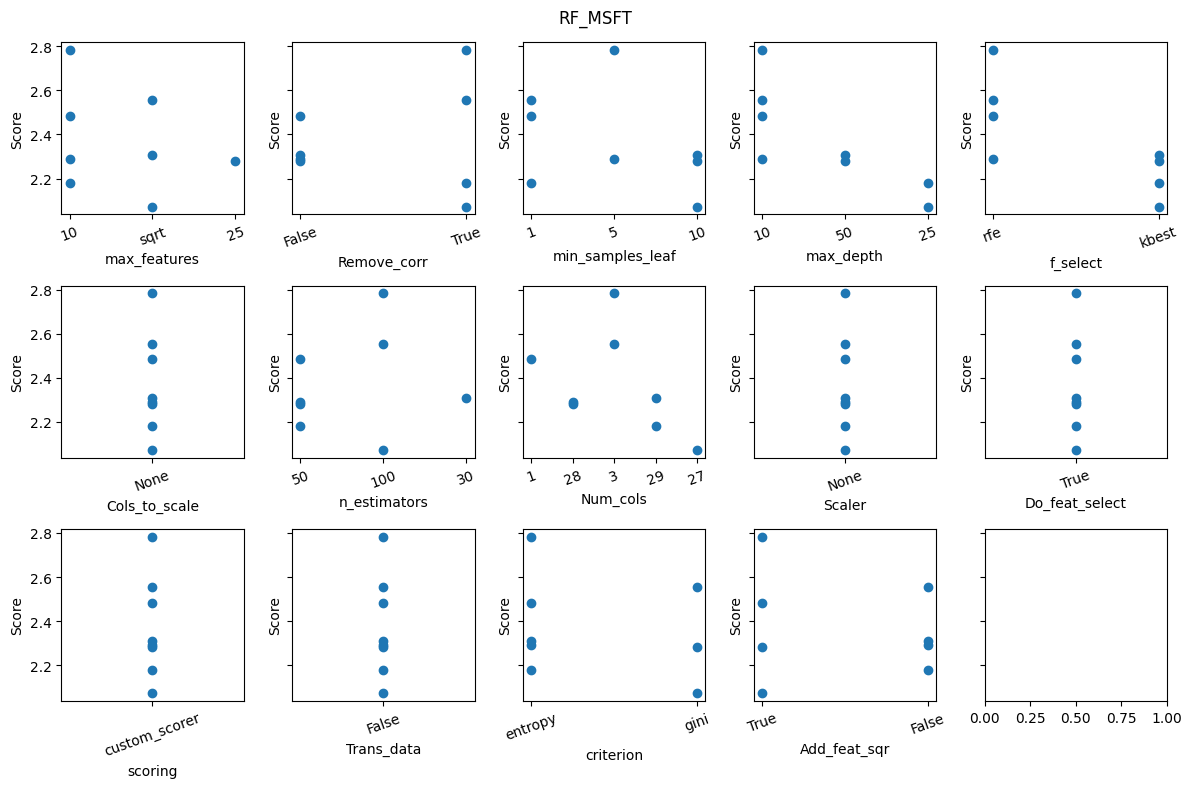

TSLA
sqlite:///./dbs/LR1.db
#####  LR_TSLA


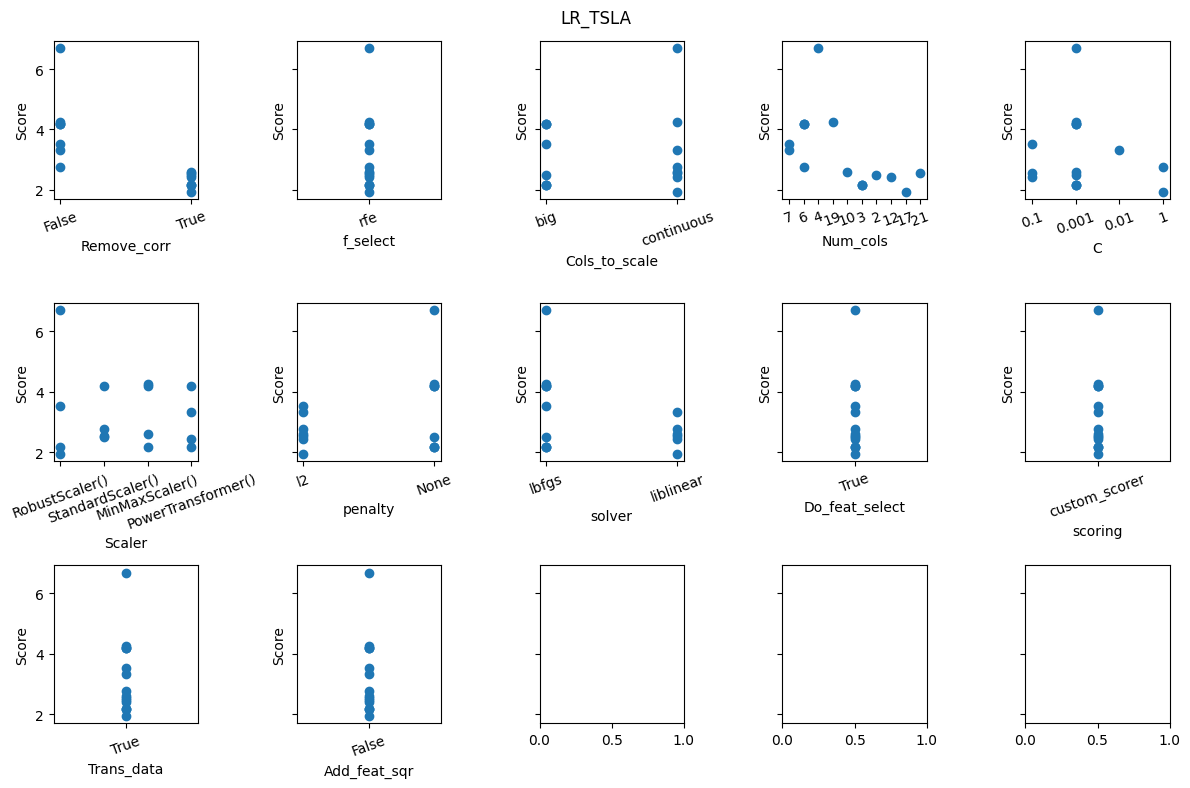

sqlite:///./dbs/MLP1.db
#####  MLP_TSLA


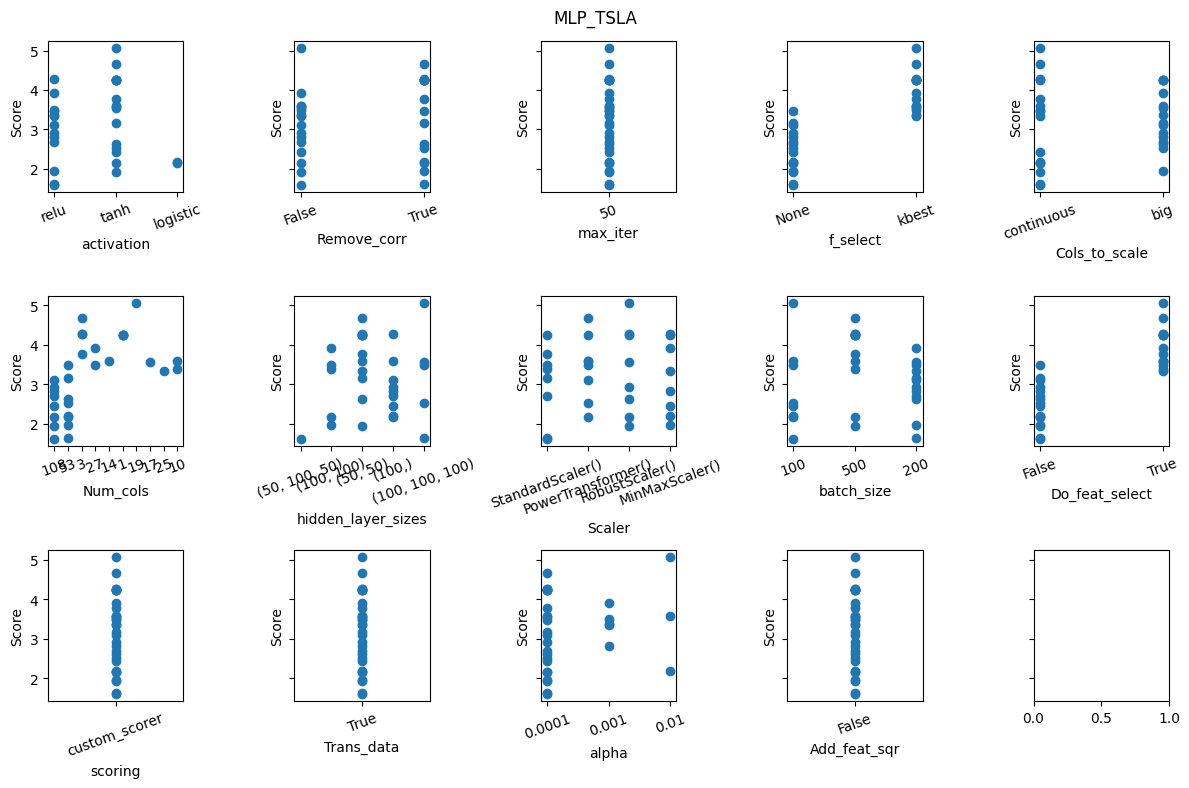

sqlite:///./dbs/RF1.db
#####  RF_TSLA


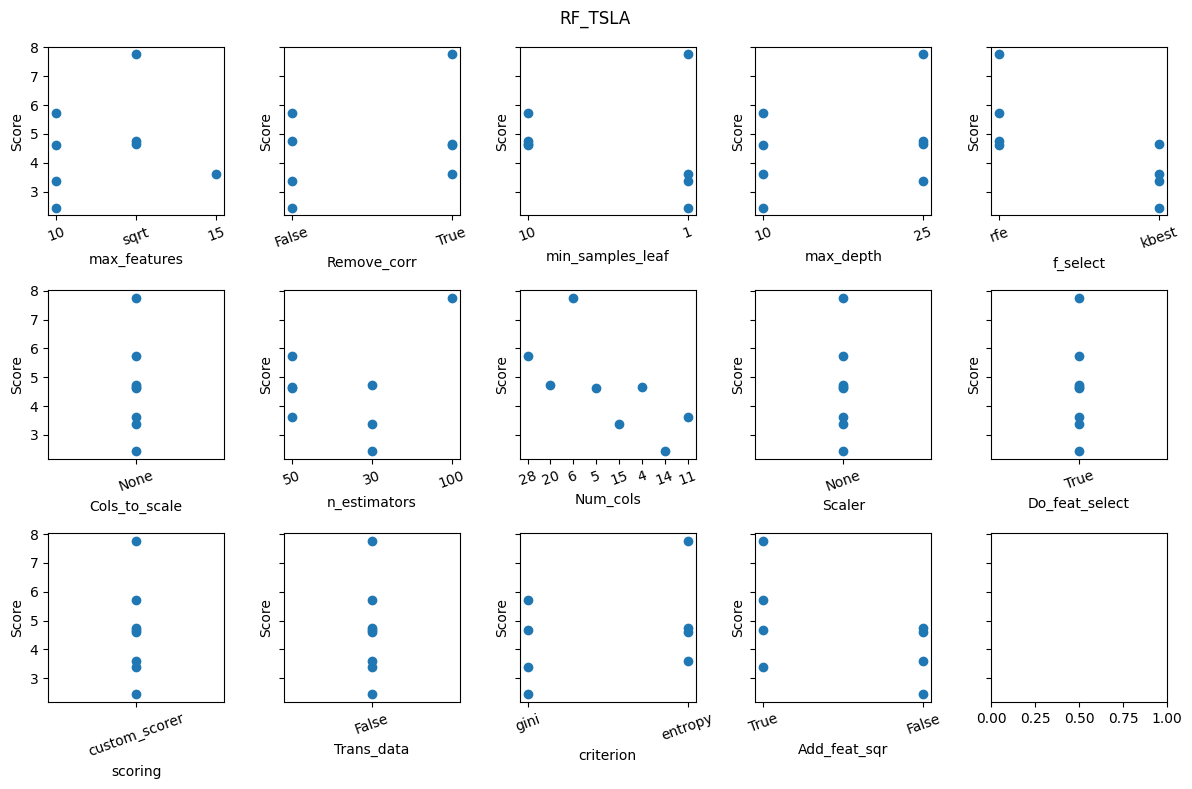

In [5]:
for s in symbols:
    print(s)
    for archivo in os.listdir(path_dbs):
        path_db = f'sqlite:///{path_dbs}/{archivo}'
        print(path_db)
        mlflow.set_tracking_uri(path_db)
        exps = mlflow.search_experiments()
        for e in [e for e in exps if f'_{s}' in e.name and e.name != 'Default']:
            fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8), sharey=True)
            i, j = 0, 0
            print('##### ', e.name)
            runs = mlflow.search_runs(e.experiment_id)
            score = runs['metrics.Score']
            columns_metrics, columns_params, run_name = [c for c in runs.columns if 'metrics' in c], [c for c in runs.columns if 'params' in c], [c for c in runs.columns if 'runName' in c]
            runs = runs[columns_params]
            runs['Score'] = score
            runs.columns = [c.replace("metrics.", "").replace("params.", "").replace("tags.mlflow.", "") for c in runs.columns]
            for c in runs.columns:
                if c not in ['Score', 'Cols', 'Recall_validation']:
                    axes[i, j].scatter(x=[str(v) for v in runs[c].values], y=runs['Score'].values)
                    axes[i, j].set_xlabel(c)
                    axes[i, j].set_ylabel('Score')
                    axes[i, j].tick_params(axis='x', rotation=20)
                    j += 1
                    if j == 5:
                        j = 0
                        i += 1
            fig.suptitle(f'{archivo[:-4]}_{s}')
            plt.tight_layout()
            plt.show()

# ANALISIS DEL RENDIMIENTO DE LA ESTRATEGIA DE LOS MODELOS

In [6]:
def analizar_estrategias(symbol, path, num_exp_model=5, show_plots=True):
    data = pd.read_parquet(f'../data/final_{symbol}.parquet').rename(columns={'Adj Close': 'Adj_Close'})
    if show_plots:
        fig_val, axes_val = plt.subplots(nrows=3, ncols=num_exp_model, figsize=(20, 10), sharey='all', sharex='all')
        fig_test, axes_test = plt.subplots(nrows=3, ncols=num_exp_model, figsize=(20, 10), sharey='all', sharex='all')
        fig_val.suptitle(f'VAL_{symbol}')
        fig_test.suptitle(f'TEST_{symbol}')
        i, j = 0, 0
    tomorrow_rets = get_tomorrow_rets(data)
    print(symbol)
    for archivo in os.listdir(path):
        path_db = f'sqlite:///{path}/{archivo}'
        mlflow.set_tracking_uri(path_db)
        exps = mlflow.search_experiments()
        for e in [e for e in exps if f'_{symbol}' in e.name and e.name != 'Default']:
            print('##### ', e.name)
            runs = mlflow.search_runs(e.experiment_id)
            columns_metrics, columns_params, run_name = ([c for c in runs.columns if 'metrics' in c], [c for c in runs.columns if 'params' in c], [c for c in runs.columns if 'runName' in c])
            runs = runs[columns_metrics + columns_params + run_name]
            runs.columns = [c.replace("metrics.", "").replace("params.", "").replace("tags.mlflow.", "") for c in runs.columns]
            runs.sort_values(by='Rendimiento_stock_test', ascending=False, inplace=True)
            for k, row in runs.iloc[:num_exp_model].iterrows():
                cols = row['Cols'].strip("[]").replace("'", "").replace("\n", "").replace("Adj Close", "Adj_Close").split()
                print('################', k)
                data_aux = data.copy()
                x_train, x_test, y_train, y_test = preparar_datos(data_aux, eval(row['Remove_corr']), eval(row['Add_feat_sqr']), eval(row['Trans_data']),
                                                                  eval(row['Scaler'] if row['Trans_data'] else 'None'), row['Cols_to_scale'])
                x_train, x_test = x_train.loc[:, cols], x_test.loc[:, cols]
                clf = get_clf(archivo, row)
                title = f"{archivo}_{row['runName']}"
                print(title)
                data_val, (at, bat, ret, pt, rst) = evaluar(clf, x_train, x_test, y_train, y_test, tomorrow_rets, .8, show_plots,
                                                            None if not show_plots else axes_val[i, j], None if not show_plots else axes_test[i, j])
                print('Accuracy test:', at)
                print('Balanced accuracy test:', bat)
                print('Recall test:', ret)
                print('Precision test:', pt)
                print('Rendimiento test:', rst)
                if show_plots:
                    axes_val[i, j].set_title(title, fontsize=6)
                    axes_test[i, j].set_title(title, fontsize=6)
                    axes_val[i, j].tick_params(axis='x', rotation=45)
                    axes_test[i, j].tick_params(axis='x', rotation=45)
                    j += 1
                    if j == num_exp_model:
                        j = 0
                        i += 1
    if show_plots:
        fig_val.tight_layout()
        fig_test.tight_layout()
        plt.show()

AAPL
#####  LR_AAPL
################ 14
LR1.db_True_False_True_RobustScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[113 204]
 [153 231]]
STOCK RETURN: 0.651542836899442
STRAT_RETURN: 1.8775207980369997
STOCK RETURN: 1.34457596183324
STRAT_RETURN: 0.6424066517124076
Accuracy test: 0.49073
Balanced accuracy test: 0.47901
Recall test: 0.60156
Precision test: 0.53103
Rendimiento test: 1.6424066517124076
################ 13
LR1.db_True_False_True_PowerTransformer()_continuous_True_rfe
Matriz de confusión en test:
 [[159 158]
 [217 167]]
STOCK RETURN: 0.651542836899442
STRAT_RETURN: 1.7496172887501742
STOCK RETURN: 1.34457596183324
STRAT_RETURN: 0.5881693615930652
Accuracy test: 0.46505
Balanced accuracy test: 0.46824
Recall test: 0.4349
Precision test: 0.51385
Rendimiento test: 1.5881693615930652
################ 15
LR1.db_True_False_True_StandardScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[164 153]
 [220 164]]
STOCK RETURN: 0.651542836899442
STRAT_RETURN: 1.65

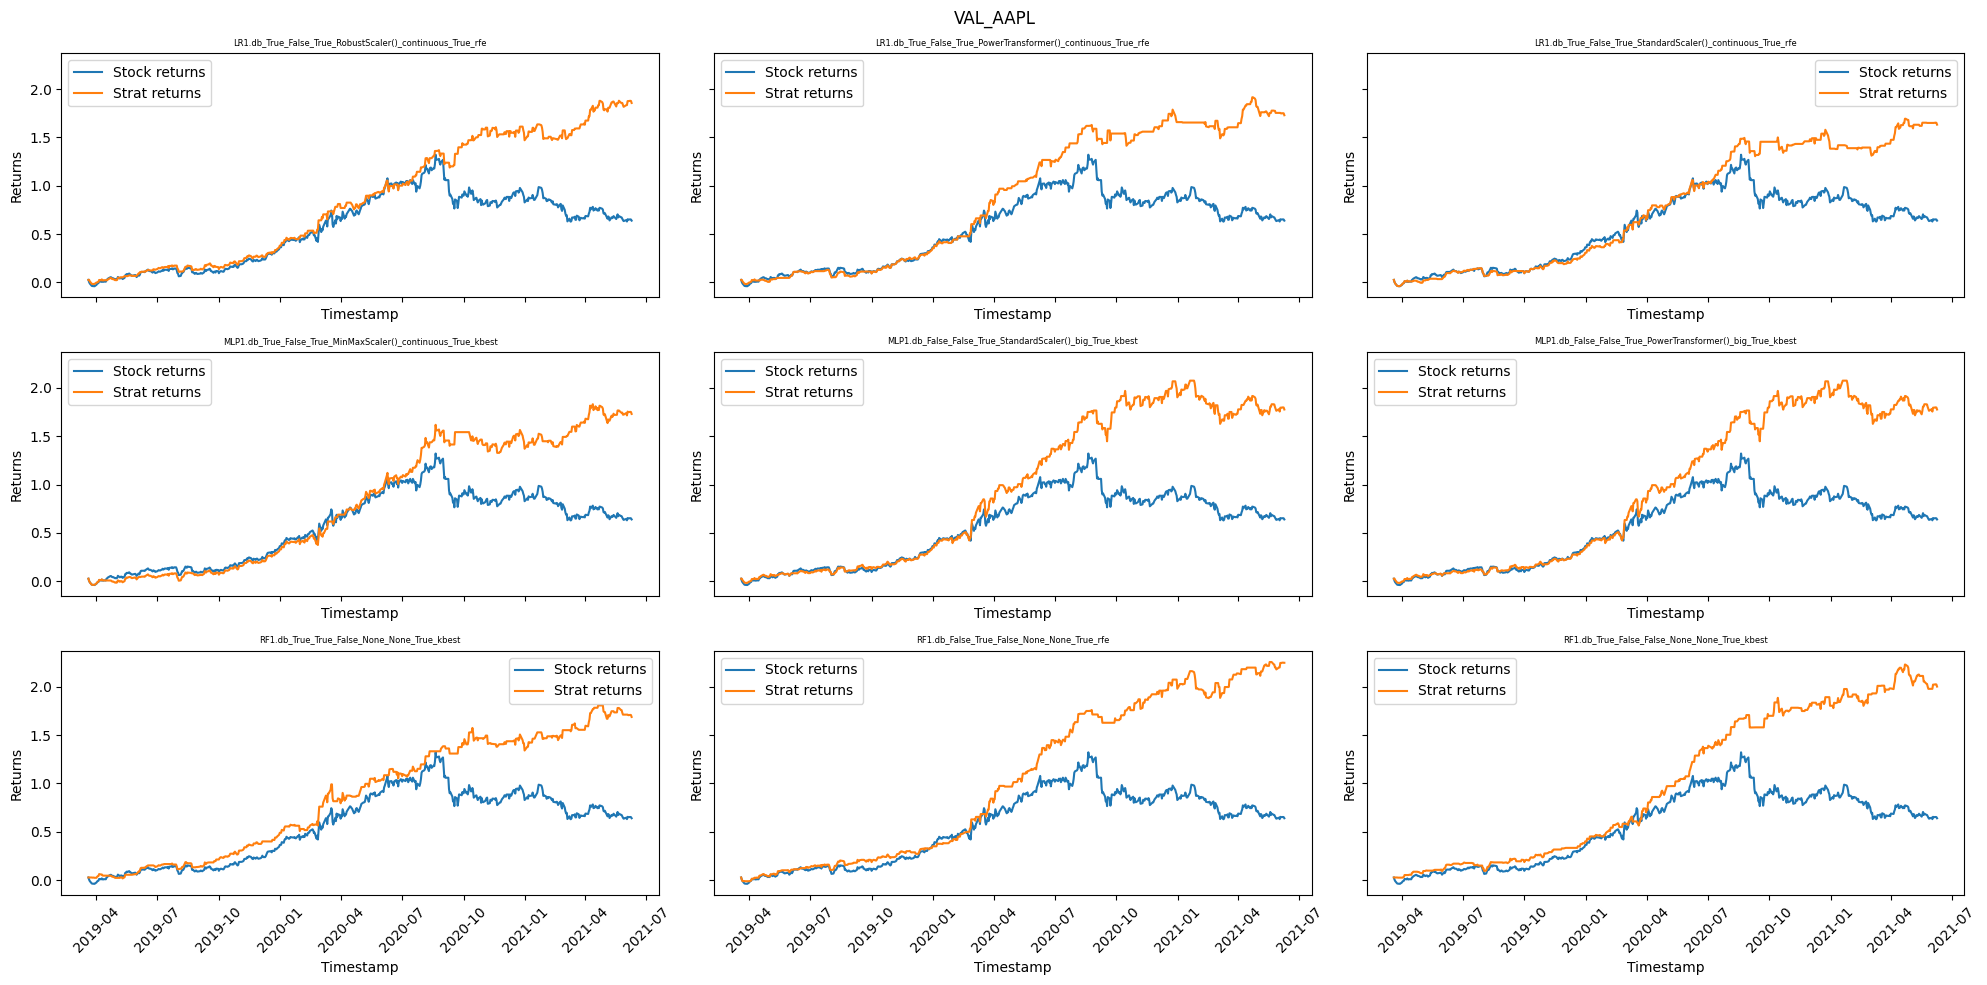

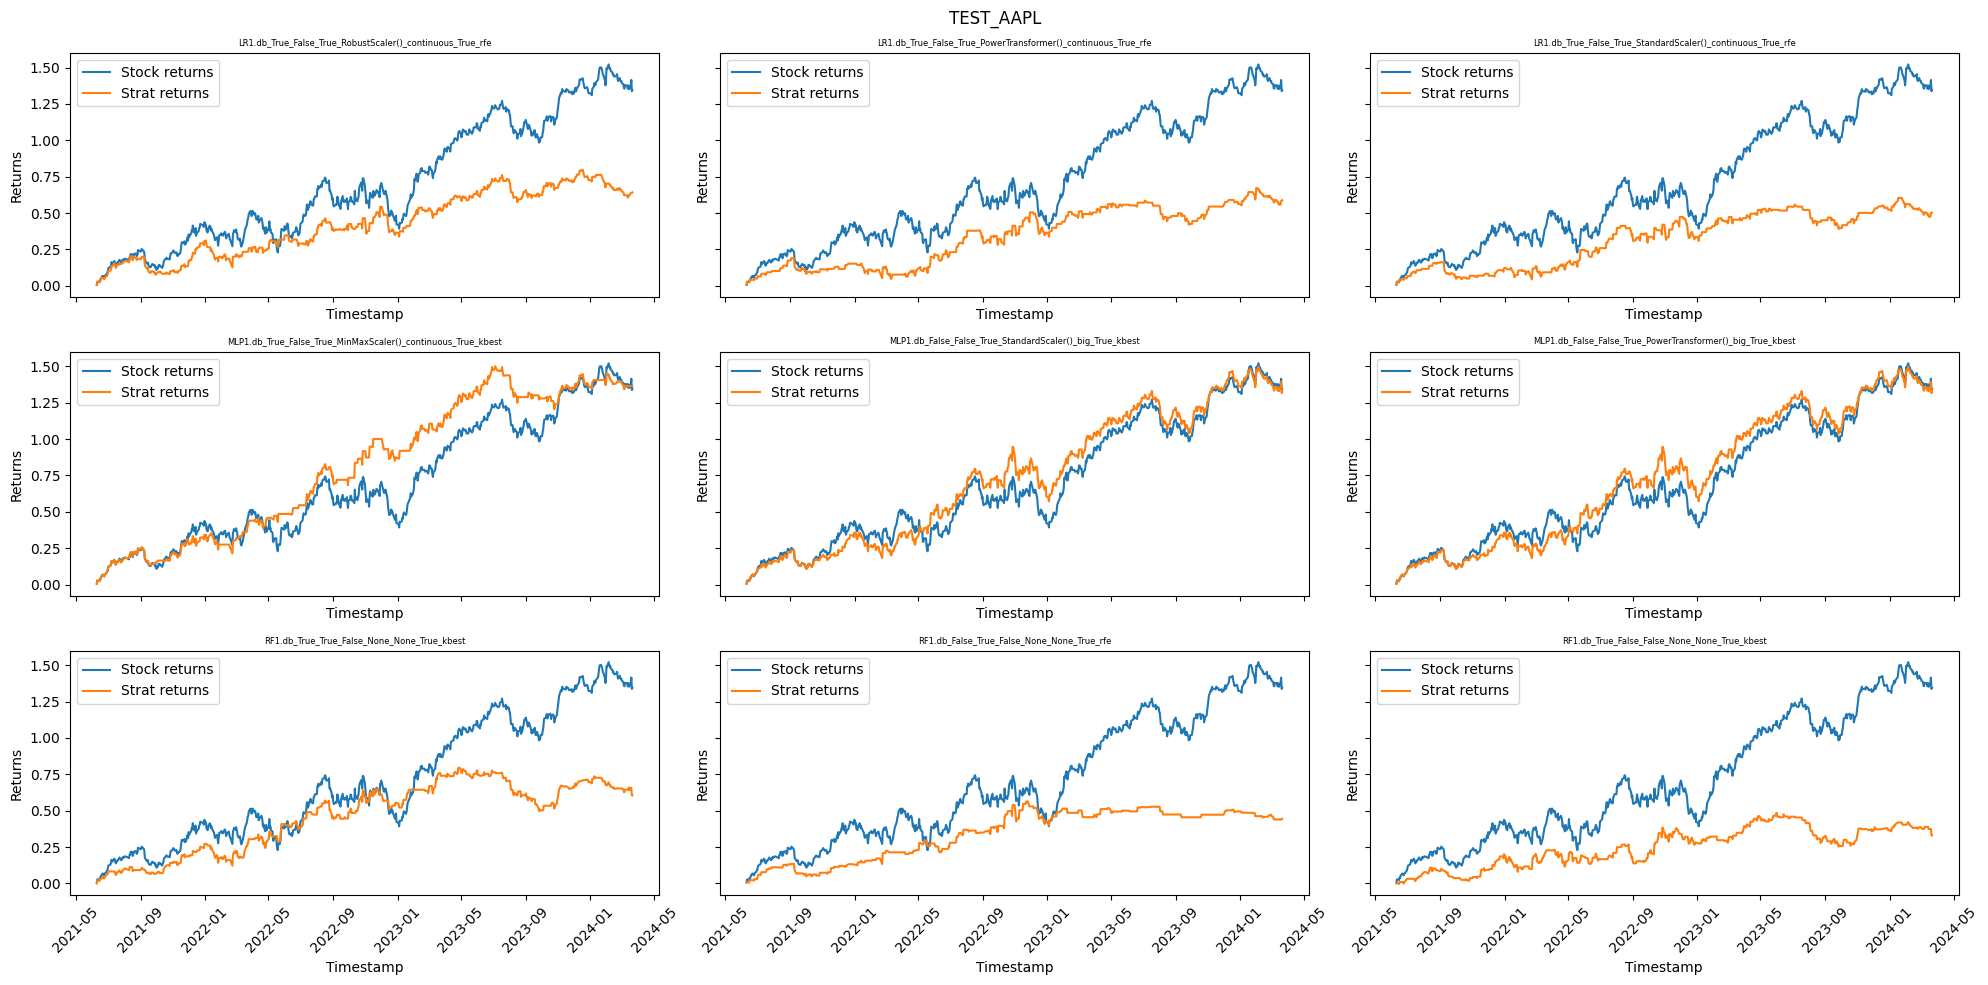

F
#####  LR_F
################ 15
LR1.db_True_False_True_PowerTransformer()_continuous_True_rfe
Matriz de confusión en test:
 [[165 200]
 [131 206]]
STOCK RETURN: -0.44306088211463857
STRAT_RETURN: 0.4682668770184084
STOCK RETURN: 0.03179717537545779
STRAT_RETURN: 1.037509499890254
Accuracy test: 0.52849
Balanced accuracy test: 0.53167
Recall test: 0.61128
Precision test: 0.50739
Rendimiento test: 2.037509499890254
################ 13
LR1.db_True_False_True_StandardScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[196 169]
 [170 167]]
STOCK RETURN: -0.44306088211463857
STRAT_RETURN: 0.5133437044548572
STOCK RETURN: 0.03179717537545779
STRAT_RETURN: 0.8773452180508015
Accuracy test: 0.51709
Balanced accuracy test: 0.51627
Recall test: 0.49555
Precision test: 0.49702
Rendimiento test: 1.8773452180508015
################ 14
LR1.db_True_False_True_RobustScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[196 169]
 [172 165]]
STOCK RETURN: -0.44306088211463857
STRAT_RETU

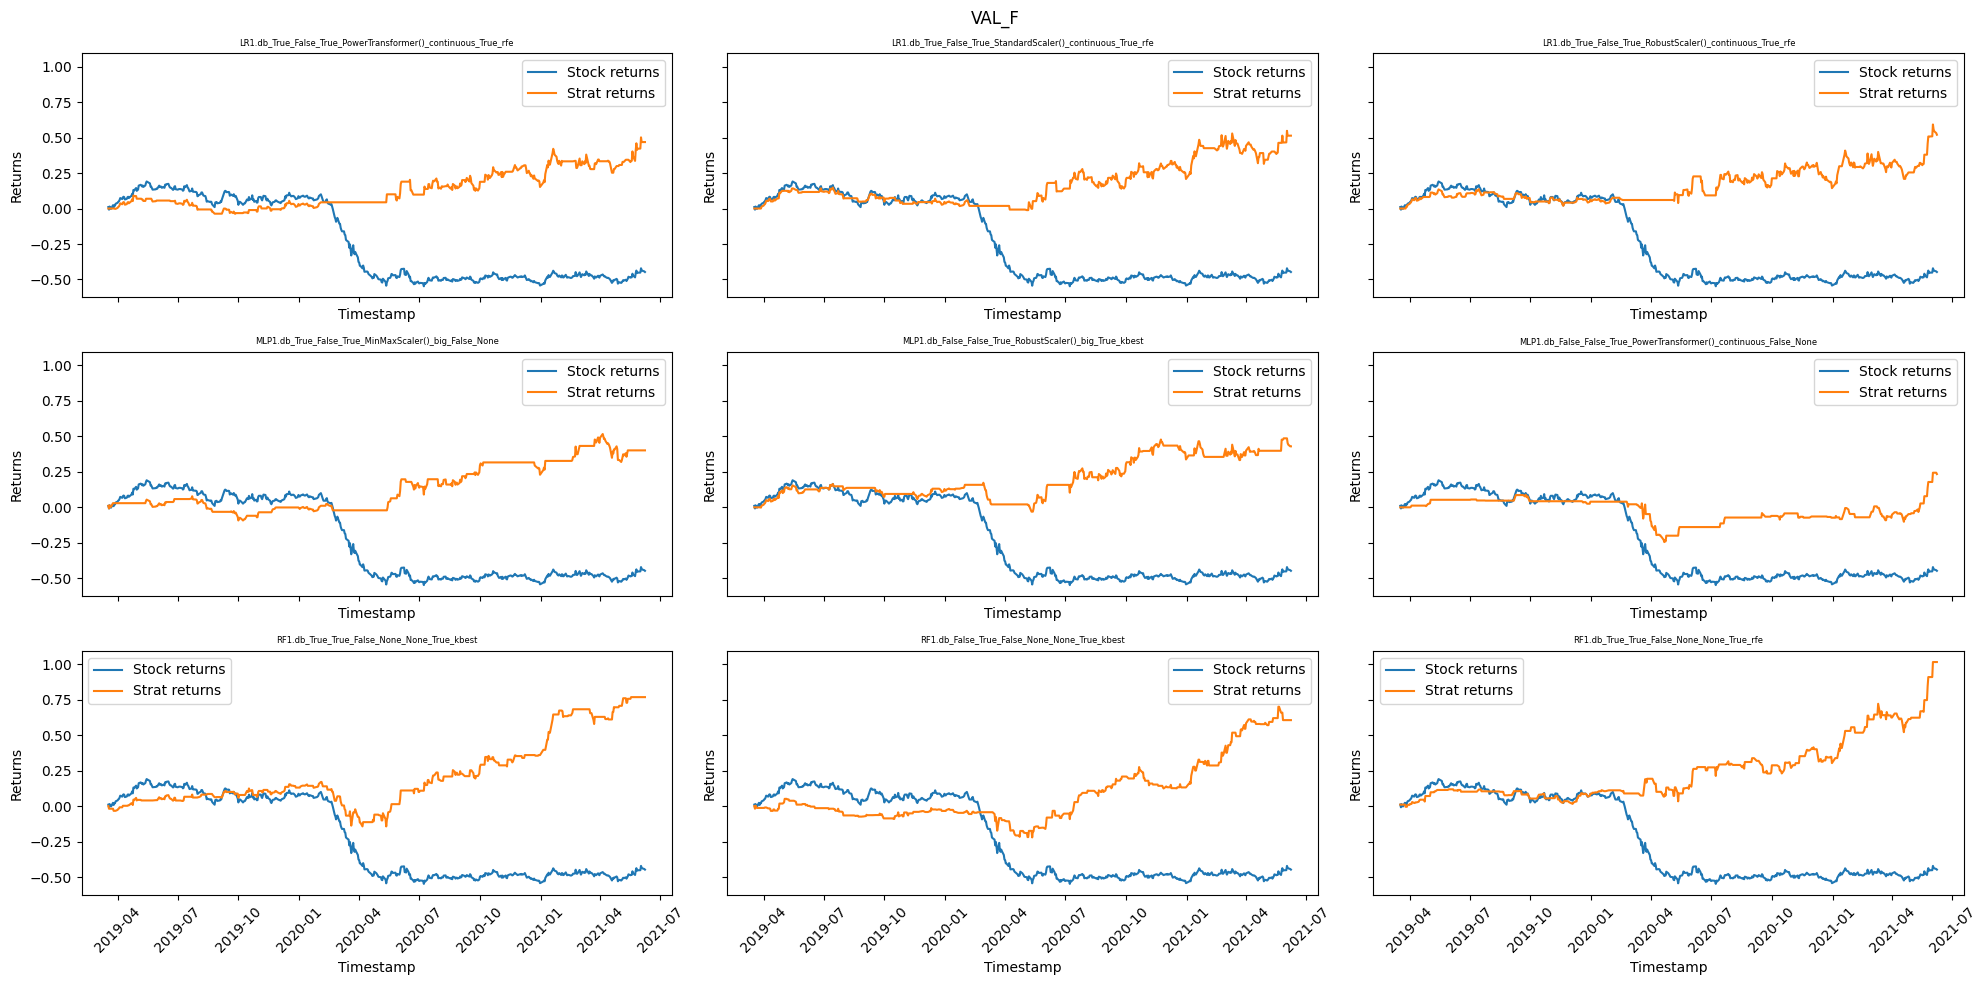

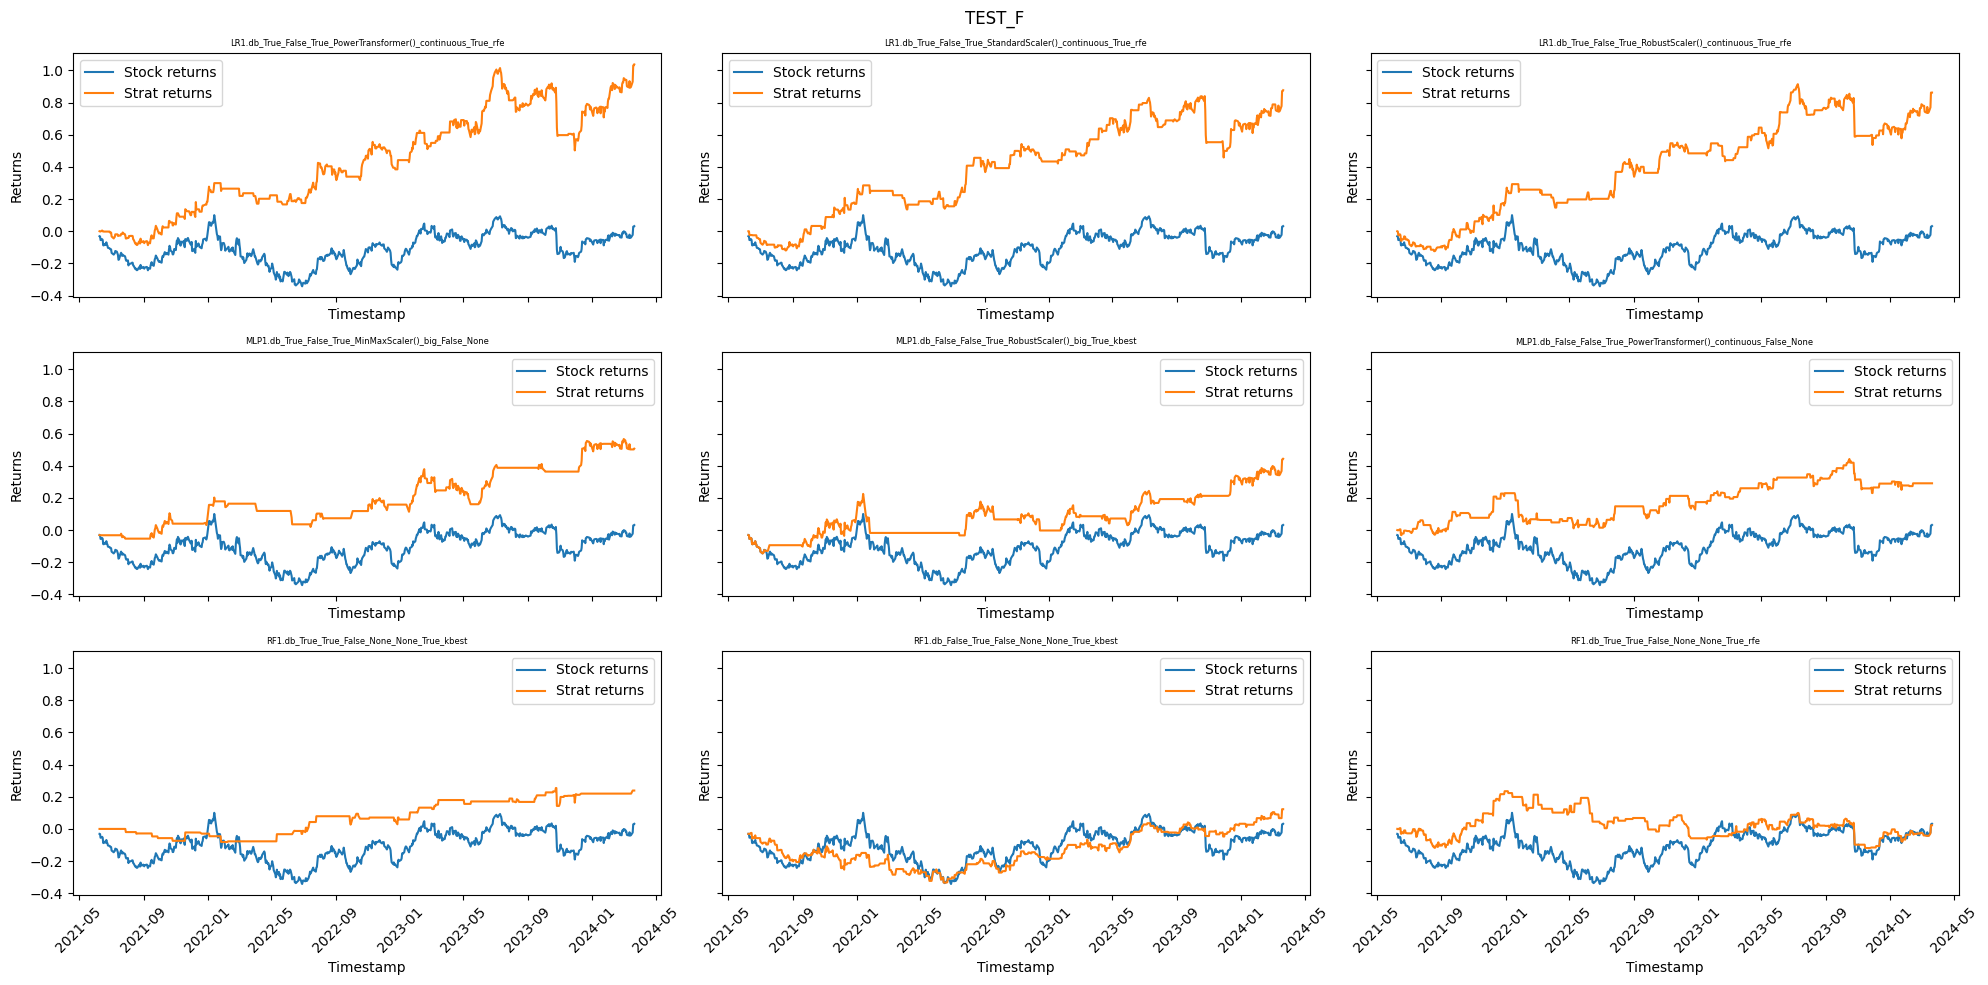

GOOG
#####  LR_GOOG
################ 7
LR1.db_False_False_True_RobustScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[  6 321]
 [  0 375]]
STOCK RETURN: 1.031669129008694
STRAT_RETURN: 1.4632109527550825
STOCK RETURN: 0.650146895736476
STRAT_RETURN: 0.7923067417652427
Accuracy test: 0.54274
Balanced accuracy test: 0.50917
Recall test: 1.0
Precision test: 0.53879
Rendimiento test: 1.7923067417652427
################ 1
LR1.db_False_False_True_StandardScaler()_big_True_rfe
Matriz de confusión en test:
 [[  4 323]
 [  2 373]]
STOCK RETURN: 1.031669129008694
STRAT_RETURN: 1.7155563269126812
STOCK RETURN: 0.650146895736476
STRAT_RETURN: 0.7319896320862846
Accuracy test: 0.53704
Balanced accuracy test: 0.50345
Recall test: 0.99467
Precision test: 0.53592
Rendimiento test: 1.7319896320862846
################ 5
LR1.db_False_False_True_MinMaxScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[  1 326]
 [  0 375]]
STOCK RETURN: 1.031669129008694
STRAT_RETURN: 1.26004012196202

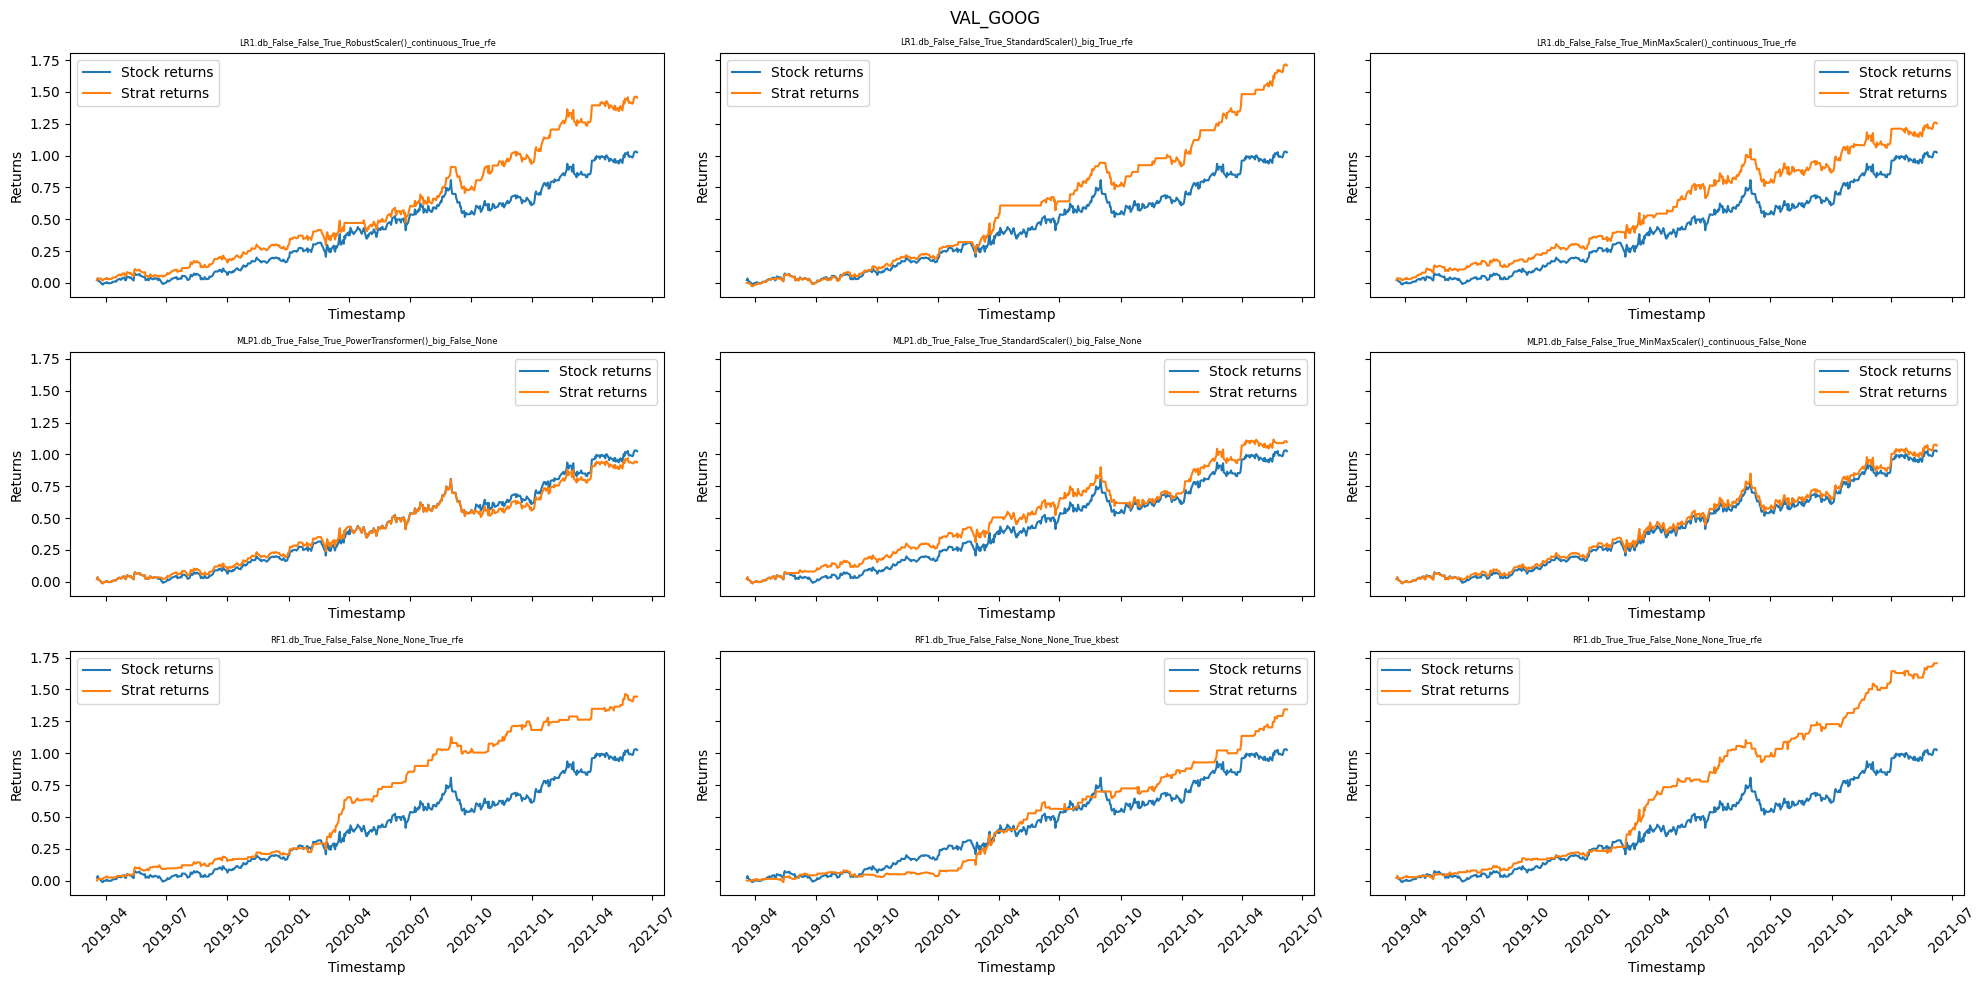

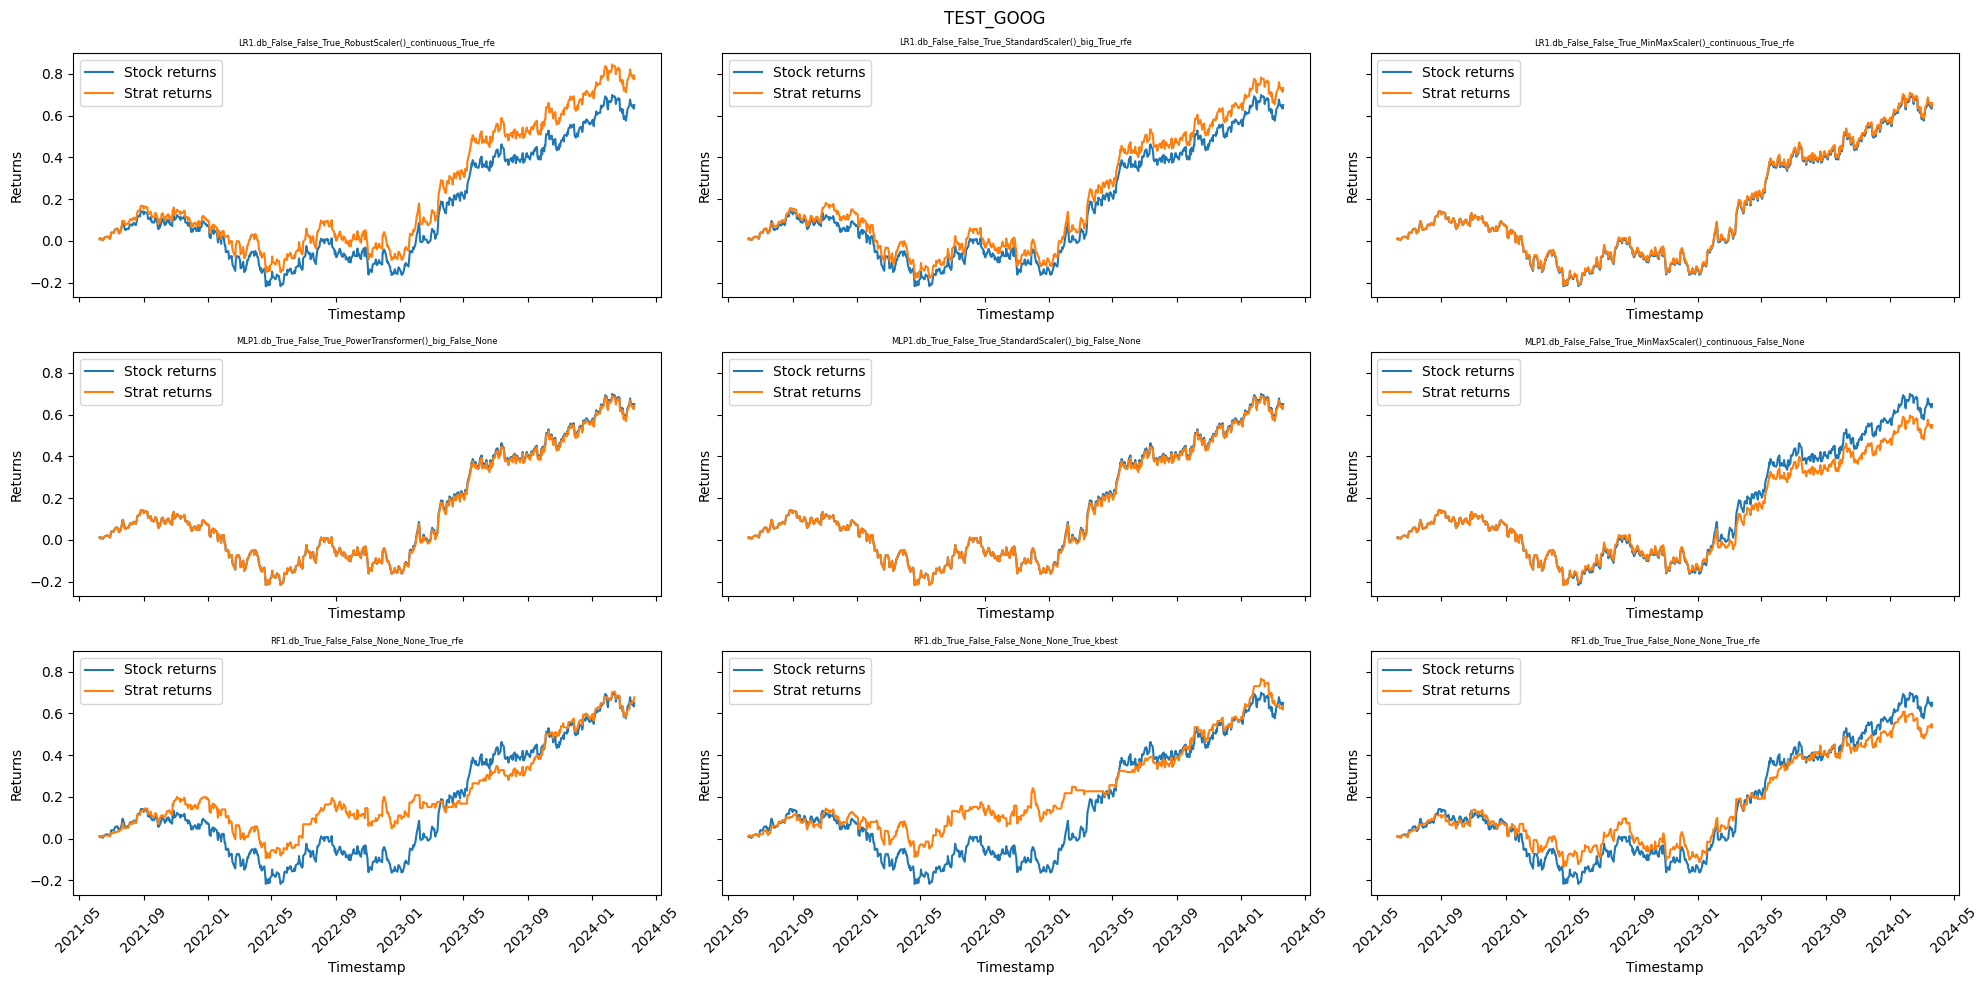

META
#####  LR_META
################ 6
LR1.db_False_False_True_RobustScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[137 128]
 [159 158]]
STOCK RETURN: 0.3309753225296901
STRAT_RETURN: 0.9681653502090939
STOCK RETURN: 1.1282539776156253
STRAT_RETURN: 1.052389950023588
Accuracy test: 0.50687
Balanced accuracy test: 0.5077
Recall test: 0.49842
Precision test: 0.55245
Rendimiento test: 2.052389950023588
################ 10
LR1.db_True_False_True_PowerTransformer()_big_True_rfe
Matriz de confusión en test:
 [[138 127]
 [157 160]]
STOCK RETURN: 0.3309753225296901
STRAT_RETURN: 0.9423909460694717
STOCK RETURN: 1.1282539776156253
STRAT_RETURN: 0.7993822624288451
Accuracy test: 0.51203
Balanced accuracy test: 0.51274
Recall test: 0.50473
Precision test: 0.55749
Rendimiento test: 1.7993822624288451
################ 7
LR1.db_False_False_True_MinMaxScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[133 132]
 [158 159]]
STOCK RETURN: 0.3309753225296901
STRAT_RETURN: 1.233304

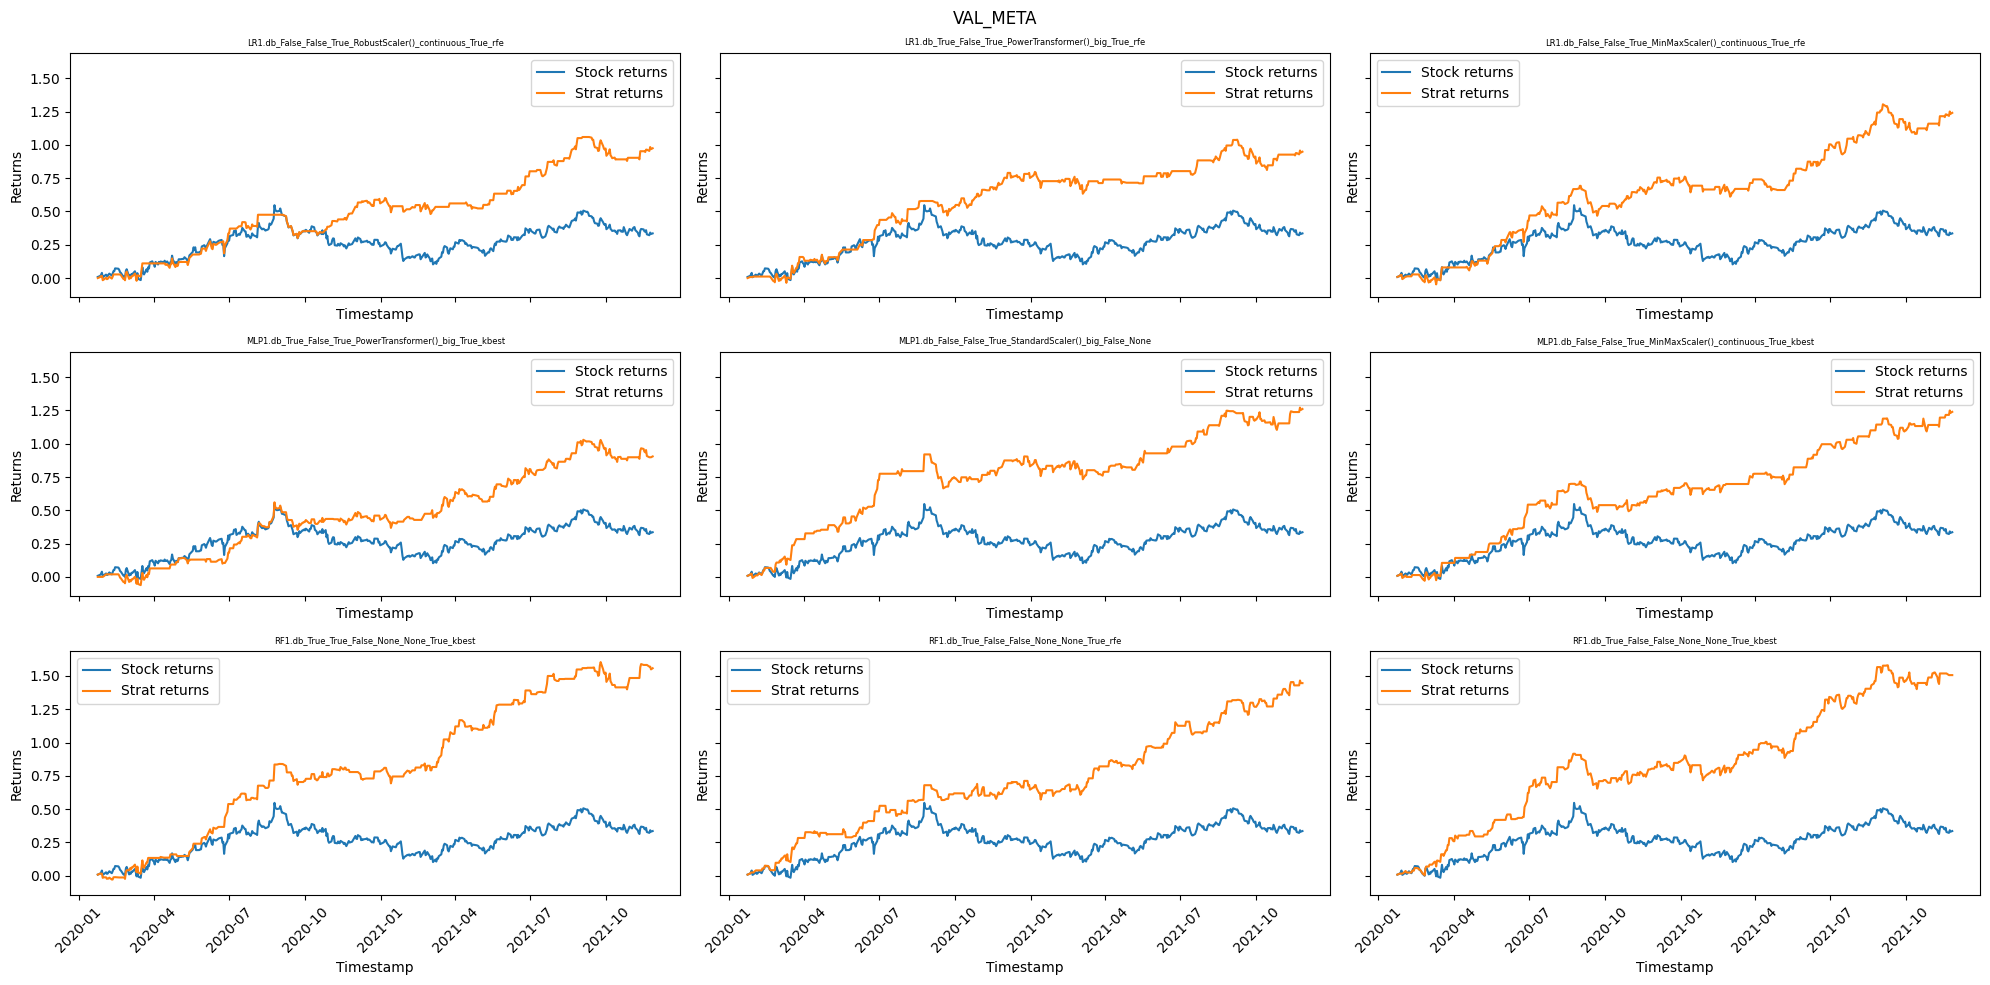

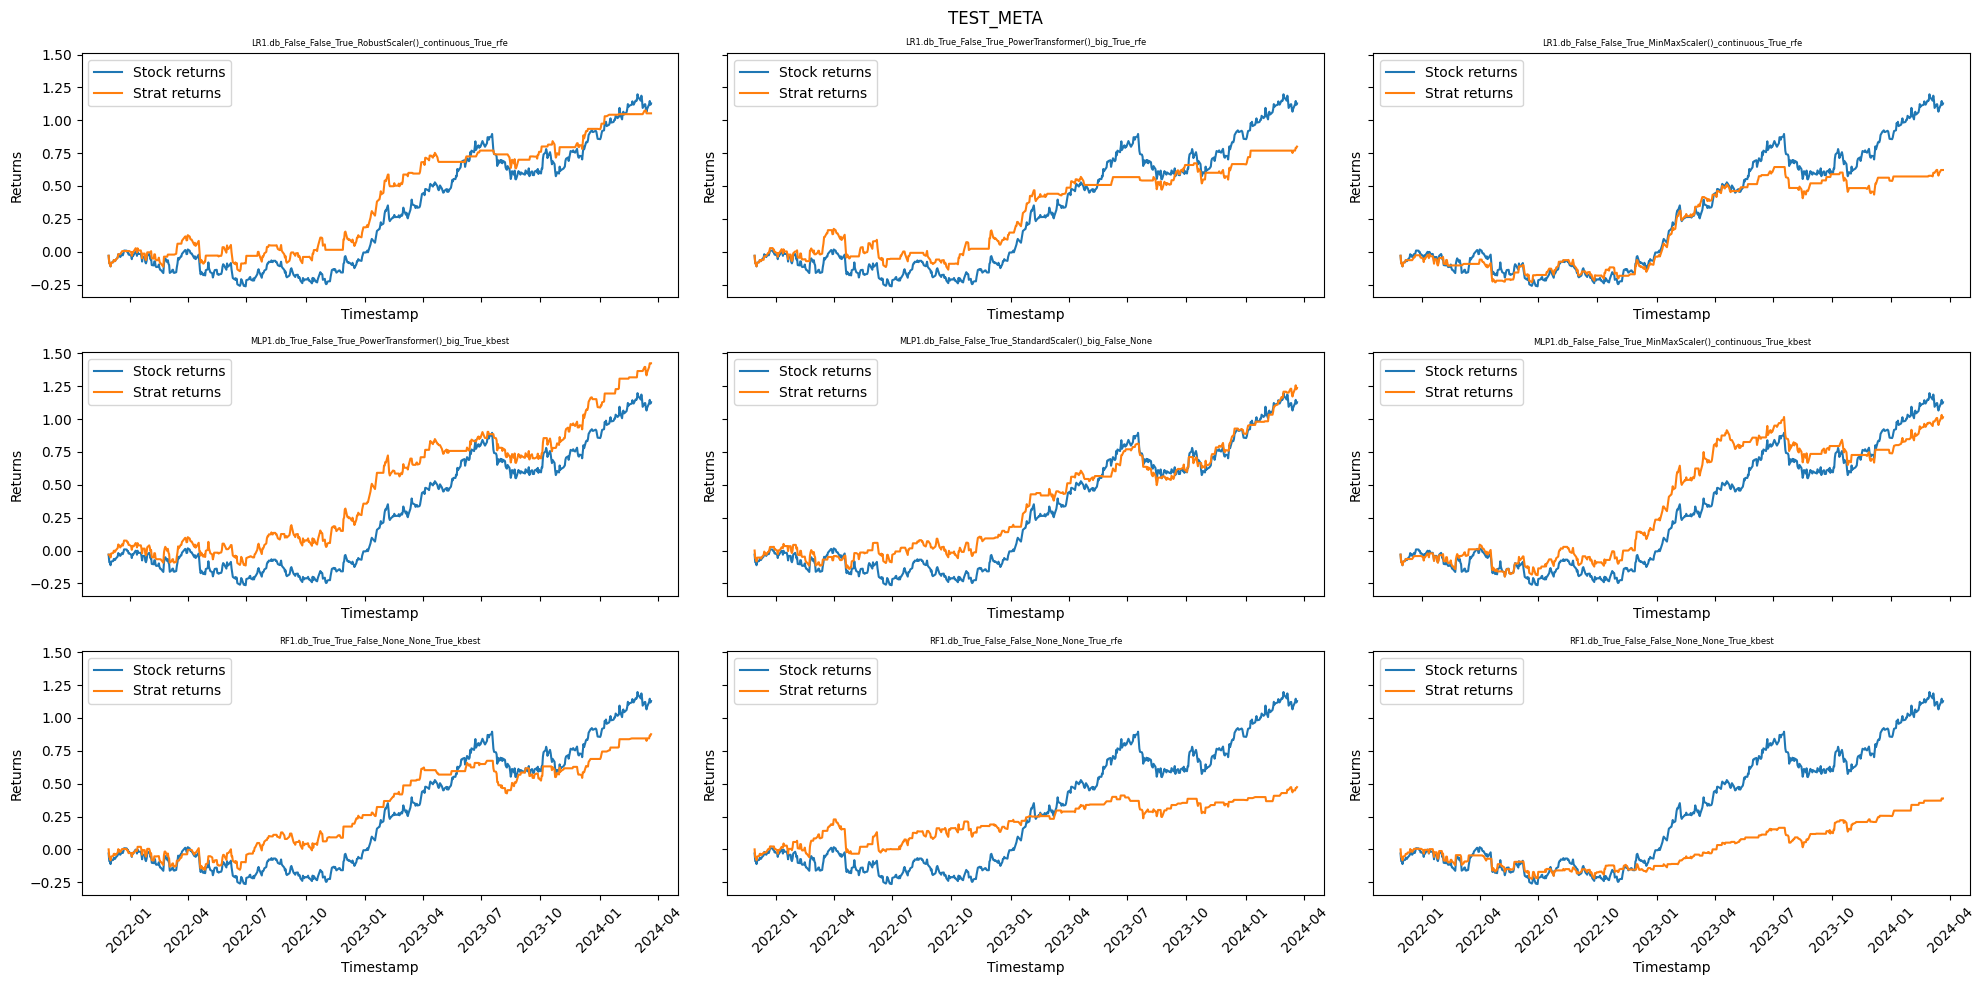

MSFT
#####  LR_MSFT
################ 8
LR1.db_True_False_True_StandardScaler()_big_True_rfe
Matriz de confusión en test:
 [[171 161]
 [191 179]]
STOCK RETURN: 0.23921860438579112
STRAT_RETURN: 1.0313726767011175
STOCK RETURN: 0.34769866419720685
STRAT_RETURN: 0.32635253442261103
Accuracy test: 0.49858
Balanced accuracy test: 0.49942
Recall test: 0.48378
Precision test: 0.52647
Rendimiento test: 1.326352534422611
################ 6
LR1.db_False_False_True_MinMaxScaler()_continuous_True_rfe
Matriz de confusión en test:
 [[137 195]
 [156 214]]
STOCK RETURN: 0.23921860438579112
STRAT_RETURN: 0.9073799023592601
STOCK RETURN: 0.34769866419720685
STRAT_RETURN: 0.24153395687642032
Accuracy test: 0.5
Balanced accuracy test: 0.49551
Recall test: 0.57838
Precision test: 0.52323
Rendimiento test: 1.2415339568764203
################ 12
LR1.db_True_False_True_PowerTransformer()_big_True_rfe
Matriz de confusión en test:
 [[131 201]
 [151 219]]
STOCK RETURN: 0.23921860438579112
STRAT_RETURN: 1.0615063

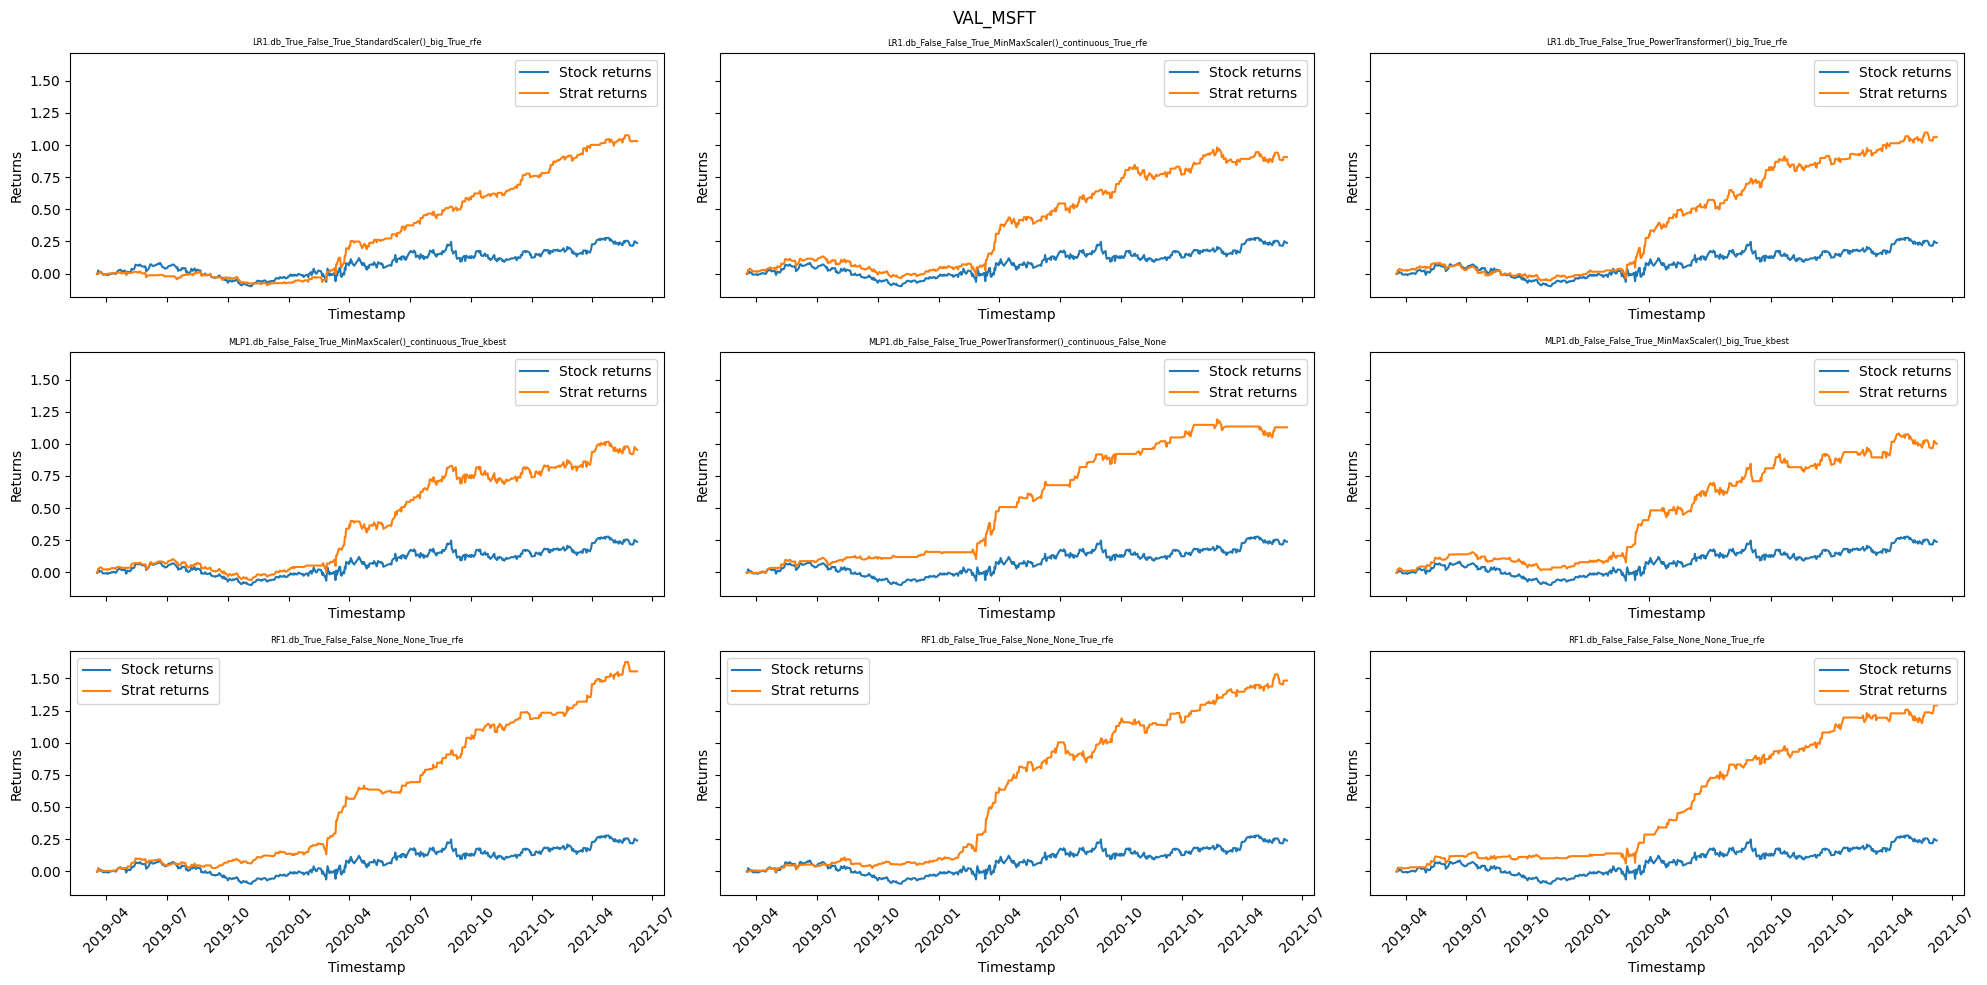

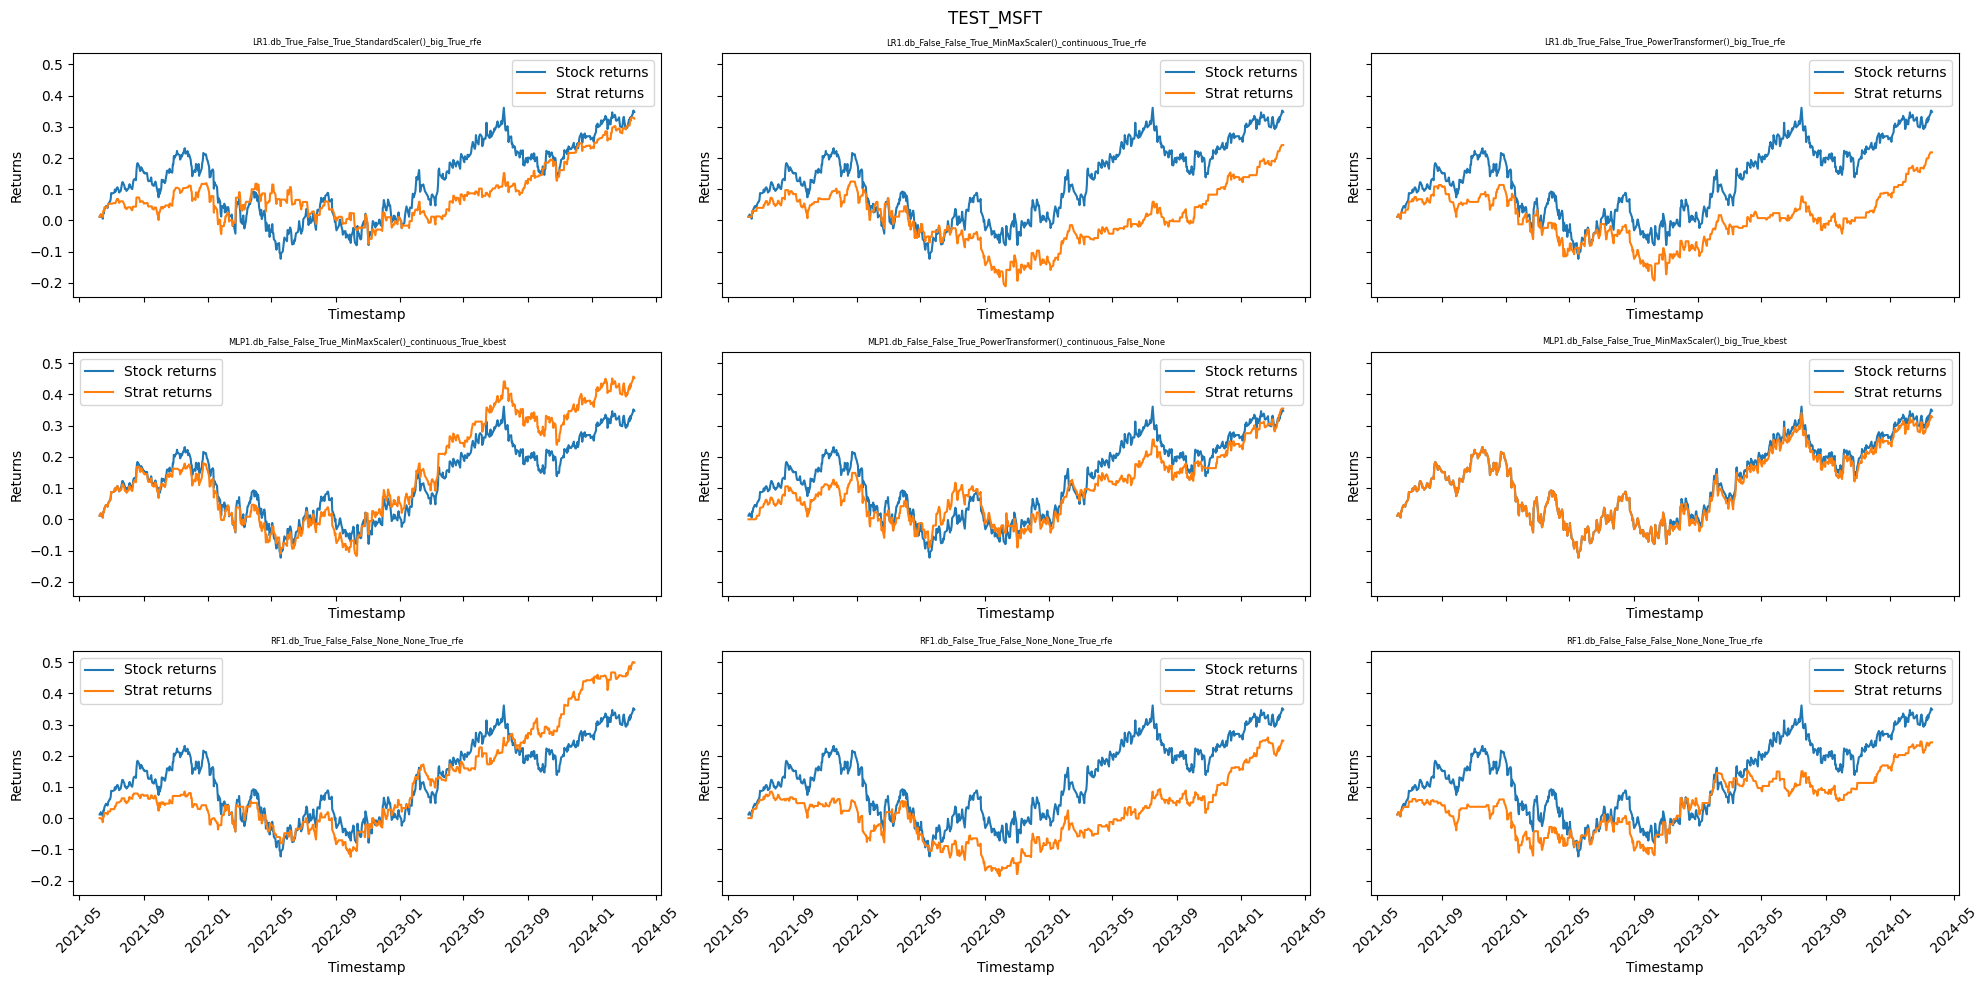

TSLA
#####  LR_TSLA
################ 1
LR1.db_False_False_True_StandardScaler()_big_True_rfe
Matriz de confusión en test:
 [[174 157]
 [152 195]]
STOCK RETURN: 1.0472970437052314
STRAT_RETURN: 3.3068742833196803
STOCK RETURN: -0.305822479676509
STRAT_RETURN: 1.8877164284732575
Accuracy test: 0.54425
Balanced accuracy test: 0.54382
Recall test: 0.56196
Precision test: 0.55398
Rendimiento test: 2.8877164284732575
################ 2
LR1.db_False_False_True_MinMaxScaler()_big_True_rfe
Matriz de confusión en test:
 [[174 157]
 [152 195]]
STOCK RETURN: 1.0472970437052314
STRAT_RETURN: 3.3068742833196803
STOCK RETURN: -0.305822479676509
STRAT_RETURN: 1.8877164284732575
Accuracy test: 0.54425
Balanced accuracy test: 0.54382
Recall test: 0.56196
Precision test: 0.55398
Rendimiento test: 2.8877164284732575
################ 3
LR1.db_False_False_True_PowerTransformer()_big_True_rfe
Matriz de confusión en test:
 [[174 157]
 [152 195]]
STOCK RETURN: 1.0472970437052314
STRAT_RETURN: 3.306874283319680

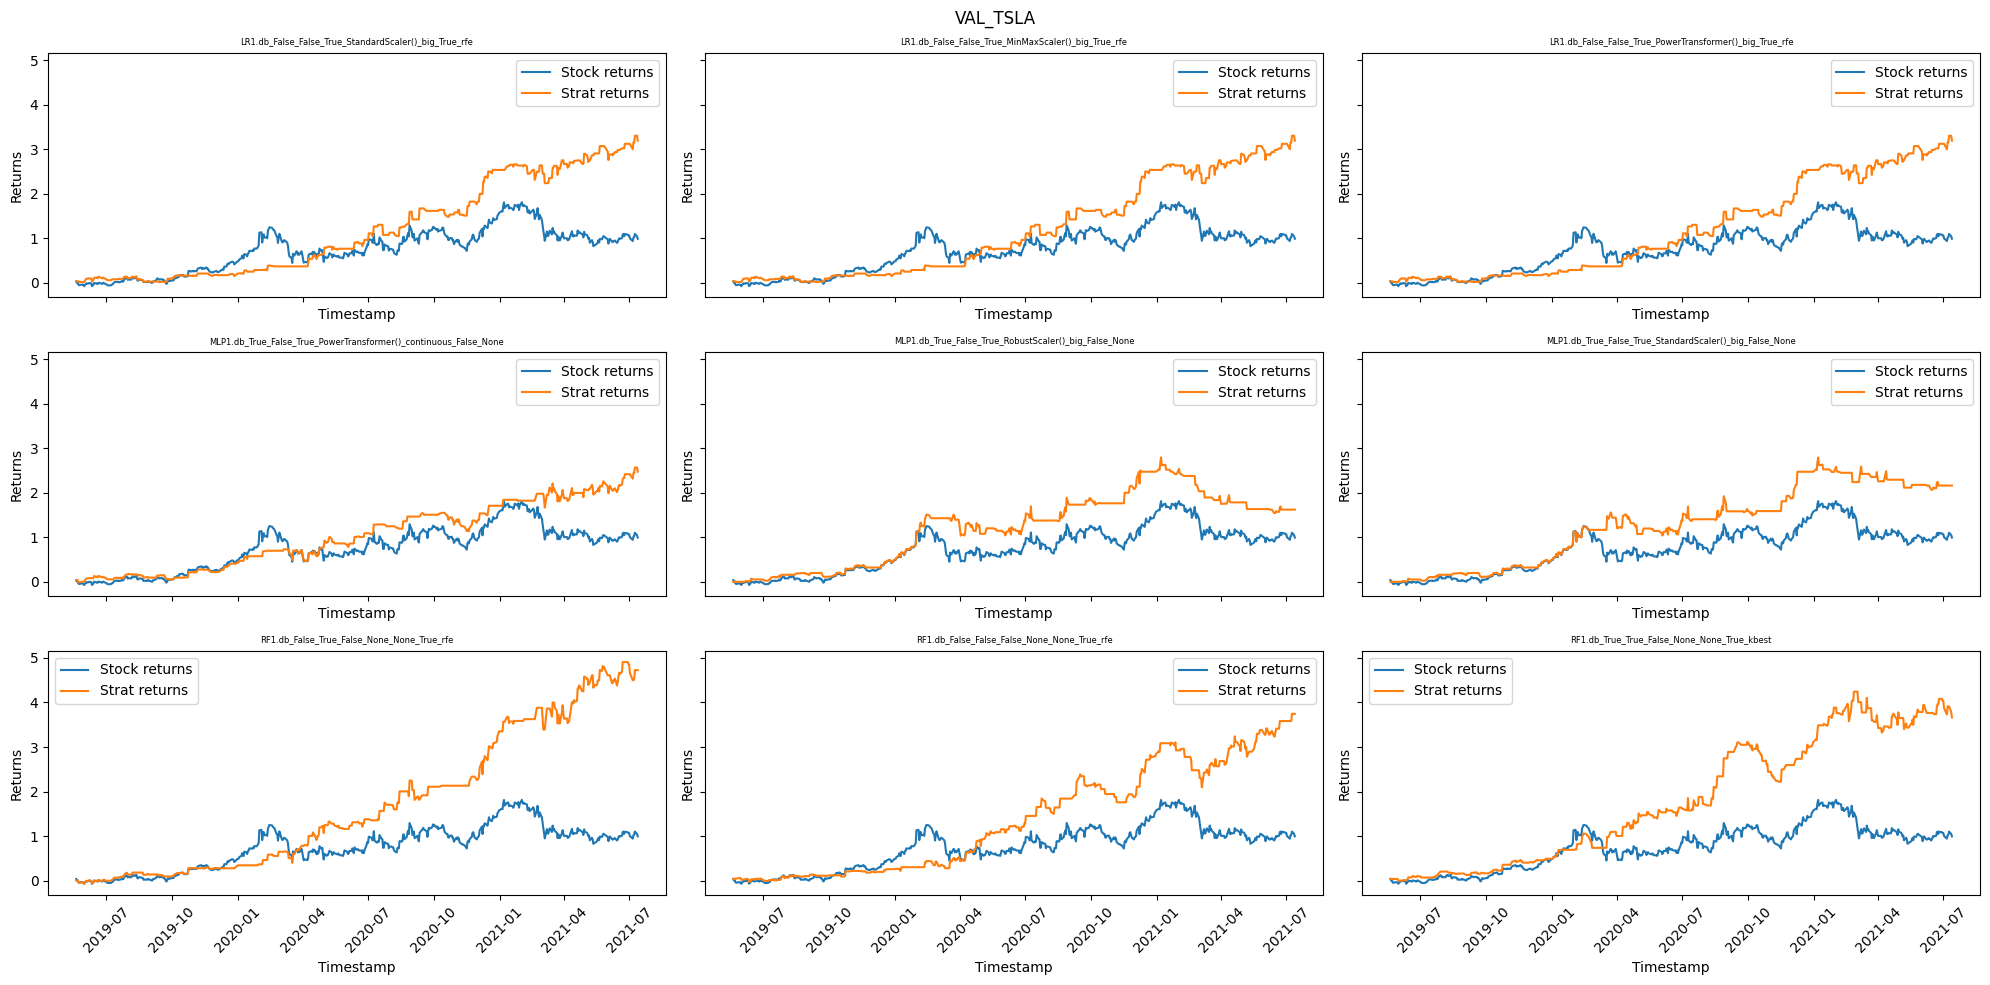

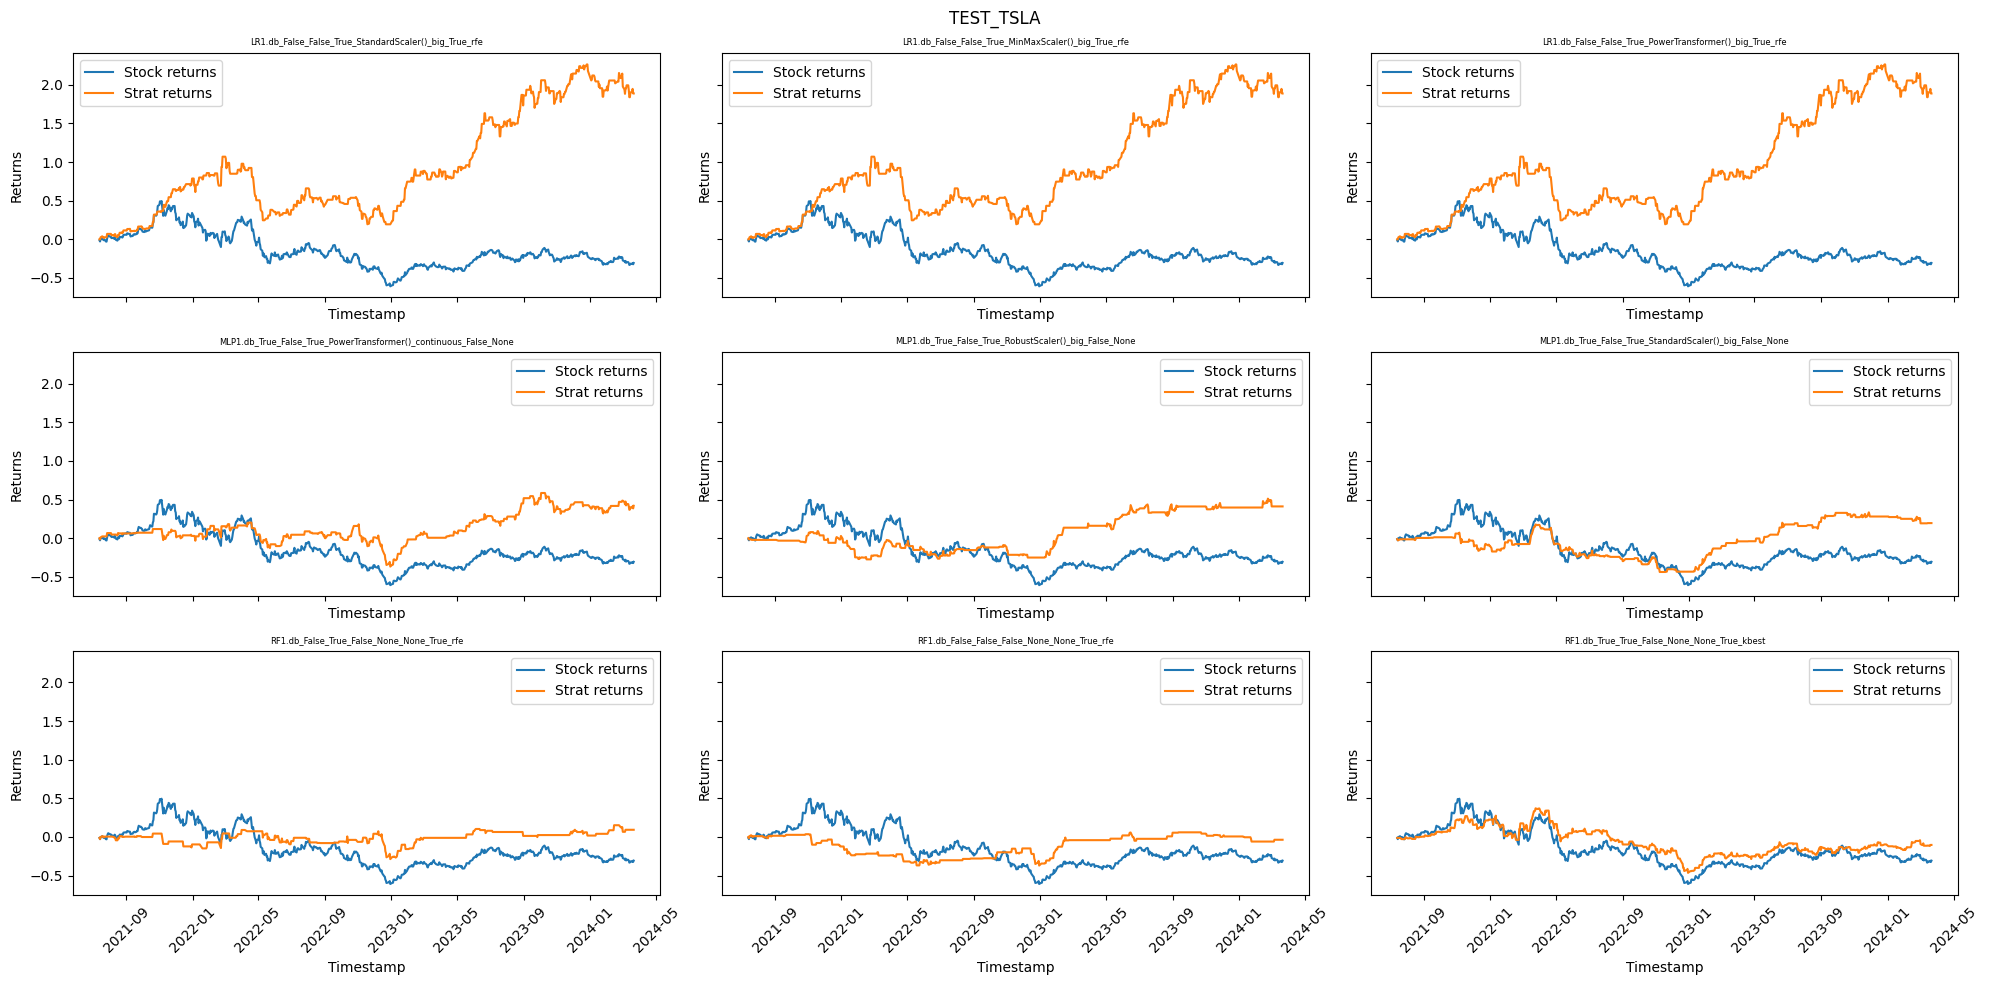

In [7]:
for s in symbols:
    analizar_estrategias(s, path_dbs, 3, True)

# ANALISIS DE LA MEDIA DE GANANCIAS Y PÉRDIDAS SI SE INVIERTE O NO

AAPL
#####  MLP_AAPL
MLP1.db_True_False_True_MinMaxScaler()_continuous_True_kbest
Media de dinero ganado cuando se invierte y se acierta: 0.011
Media de dinero perdido cuando se invierte y se falla: -0.009
Media de dinero que se podía haber ganado: 0.012
Media de dinero salvado al no invertir: -0.013

F
#####  LR_F
LR1.db_True_False_True_PowerTransformer()_continuous_True_rfe
Media de dinero ganado cuando se invierte y se acierta: 0.016
Media de dinero perdido cuando se invierte y se falla: -0.013
Media de dinero que se podía haber ganado: 0.017
Media de dinero salvado al no invertir: -0.018

GOOG
#####  RF_GOOG
RF1.db_True_False_False_None_None_True_rfe
Media de dinero ganado cuando se invierte y se acierta: 0.012
Media de dinero perdido cuando se invierte y se falla: -0.012
Media de dinero que se podía haber ganado: 0.012
Media de dinero salvado al no invertir: -0.012

META
#####  RF_META__
RF1.db_True_True_False_None_None_True_kbest
Media de dinero ganado cuando se invierte y se aci

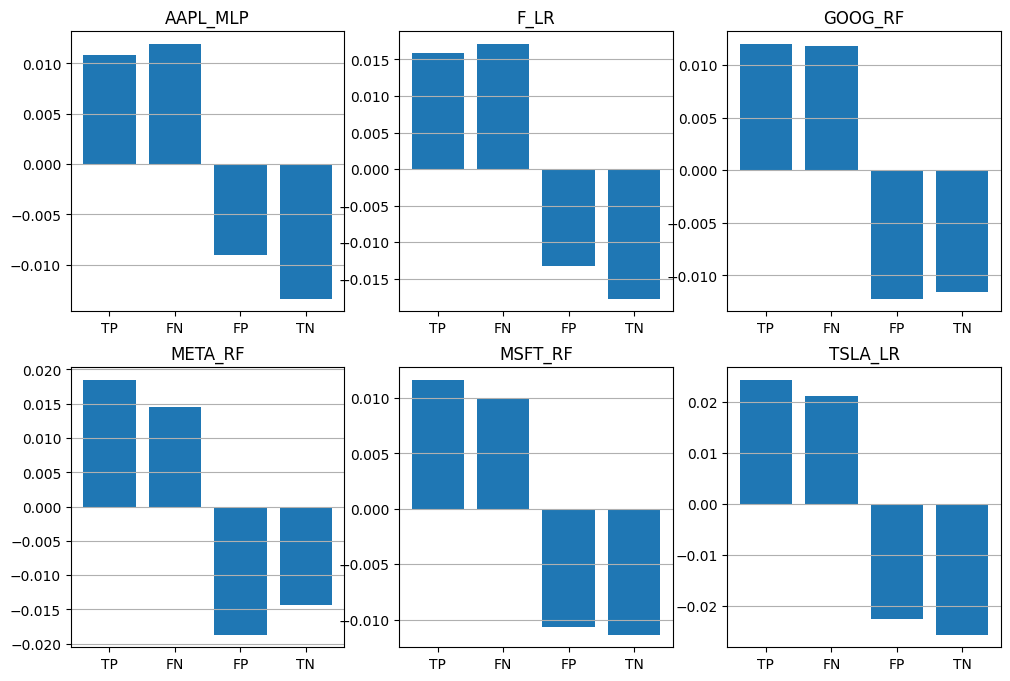

In [9]:
def analasis_perdidas_ganancias(symbol, path, ax):
    data = pd.read_parquet(f'../data/final_{symbol}.parquet').rename(columns={'Adj Close': 'Adj_Close'})
    tomorrow_rets = get_tomorrow_rets(data)
    print(symbol)
    for archivo in os.listdir(path):
        path_db = f'sqlite:///{path}/{archivo}'
        mlflow.set_tracking_uri(path_db)
        exps = mlflow.search_experiments()
        for e in [e for e in exps if f'_{symbol}' in e.name and e.name != 'Default']:
            if (archivo == 'RF1.db' and symbol in ['GOOG', 'META', 'MSFT']) or (archivo == 'LR1.db' and symbol in ['F', 'TSLA']) or (archivo == 'MLP1.db' and symbol in ['AAPL']):
                print('##### ', e.name)
                runs = mlflow.search_runs(e.experiment_id)
                columns_metrics, columns_params, run_name = ([c for c in runs.columns if 'metrics' in c], [c for c in runs.columns if 'params' in c], [c for c in runs.columns if 'runName' in c])
                runs = runs[columns_metrics + columns_params + run_name]
                runs.columns = [c.replace("metrics.", "").replace("params.", "").replace("tags.mlflow.", "") for c in runs.columns]
                runs.sort_values(by='Rendimiento_stock_test', ascending=False, inplace=True)
                best = runs.iloc[0]
                cols = best['Cols'].strip("[]").replace("'", "").replace("\n", "").replace("Adj Close", "Adj_Close").split()
                data_aux = data.copy()
                x_train, x_test, y_train, y_test = preparar_datos(data_aux, eval(best['Remove_corr']), eval(best['Add_feat_sqr']), eval(best['Trans_data']),
                                                                  eval(best['Scaler'] if best['Trans_data'] else 'None'), best['Cols_to_scale'])
                x_train, x_test = x_train.loc[:, cols], x_test.loc[:, cols]
                aux_tmrw_rets = tomorrow_rets.loc[x_test.index]
                clf = get_clf(archivo, best)
                title = f"{archivo}_{best['runName']}"
                print(title)
                clf.fit(x_train, y_train)
                y_pred = clf.predict(x_test)
                tp, tn, fp, fn = (aux_tmrw_rets[(y_pred == 1) & (aux_tmrw_rets > 0)],
                                  aux_tmrw_rets[(y_pred == 0) & (aux_tmrw_rets < 0)],
                                  aux_tmrw_rets[(y_pred == 1) & (aux_tmrw_rets < 0)],
                                  aux_tmrw_rets[(y_pred == 0) & (aux_tmrw_rets > 0)])
                print('Media de dinero ganado cuando se invierte y se acierta:', round(tp.mean(), 3))
                print('Media de dinero perdido cuando se invierte y se falla:', round(fp.mean(), 3))
                print('Media de dinero que se podía haber ganado:', round(fn.mean(), 3))
                print('Media de dinero salvado al no invertir:', round(tn.mean(), 3))
                print()
                ax.bar(x=['TP', 'FN', 'FP', 'TN'], height=[tp.mean(), fn.mean(), fp.mean(), tn.mean()])
                ax.grid(True, axis='y')
                ax.set_title(f'{symbol}_{archivo[:-4]}')
                return

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
i, j = 0, 0
for s in symbols:
    analasis_perdidas_ganancias(s, path_dbs, axes[i, j])
    j += 1
    if j == 3:
        j = 0
        i += 1

# ANALISIS IMPORTANCIA DE LAS VARIABLES

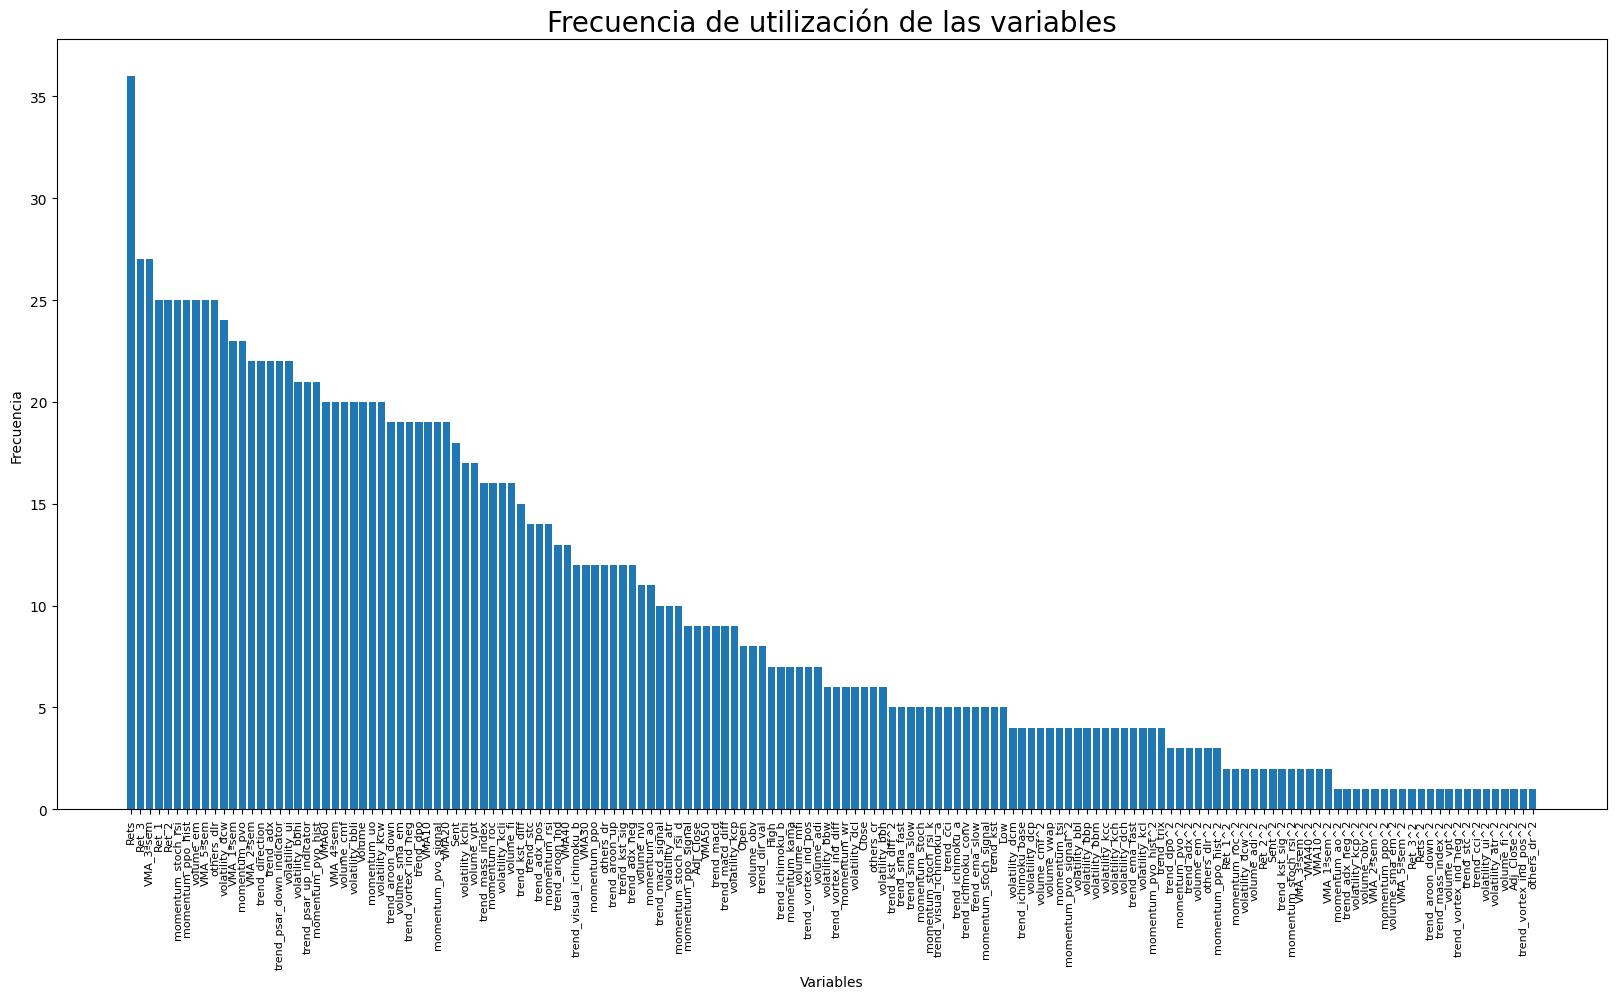

In [10]:
def analasis_variables(symbol, path, todas_cols, max_runs=5):
    data = pd.read_parquet(f'../data/final_{symbol}.parquet').rename(columns={'Adj Close': 'Adj_Close'})
    for archivo in os.listdir(path):
        path_db = f'sqlite:///{path}/{archivo}'
        mlflow.set_tracking_uri(path_db)
        exps = mlflow.search_experiments()
        for e in [e for e in exps if f'_{symbol}' in e.name and e.name != 'Default']:
            runs = mlflow.search_runs(e.experiment_id)
            columns_metrics, columns_params, run_name = ([c for c in runs.columns if 'metrics' in c], [c for c in runs.columns if 'params' in c], [c for c in runs.columns if 'runName' in c])
            runs = runs[columns_metrics + columns_params + run_name]
            runs.columns = [c.replace("metrics.", "").replace("params.", "").replace("tags.mlflow.", "") for c in runs.columns]
            runs.sort_values(by='Rendimiento_stock_test', ascending=False, inplace=True)
            for k, row in runs.iloc[:max_runs].iterrows():
                todas_cols.append(row['Cols'].strip("[]").replace("'", "").replace("\n", "").replace("Adj Close", "Adj_Close").split())
                
todas_cols = []
for s in symbols:
    analasis_variables(s, path_dbs, todas_cols, 3)
frecuencia_variables = pd.Series([c for cols in todas_cols for c in cols]).value_counts()
fig, axes = plt.subplots(figsize=(20, 10))
axes.bar(frecuencia_variables.index, height=frecuencia_variables)
axes.tick_params(axis='x', labelsize=8, rotation=90)
axes.set_xlabel('Variables')
axes.set_ylabel('Frecuencia')
axes.set_title('Frecuencia de utilización de las variables', fontsize=20)
plt.show()

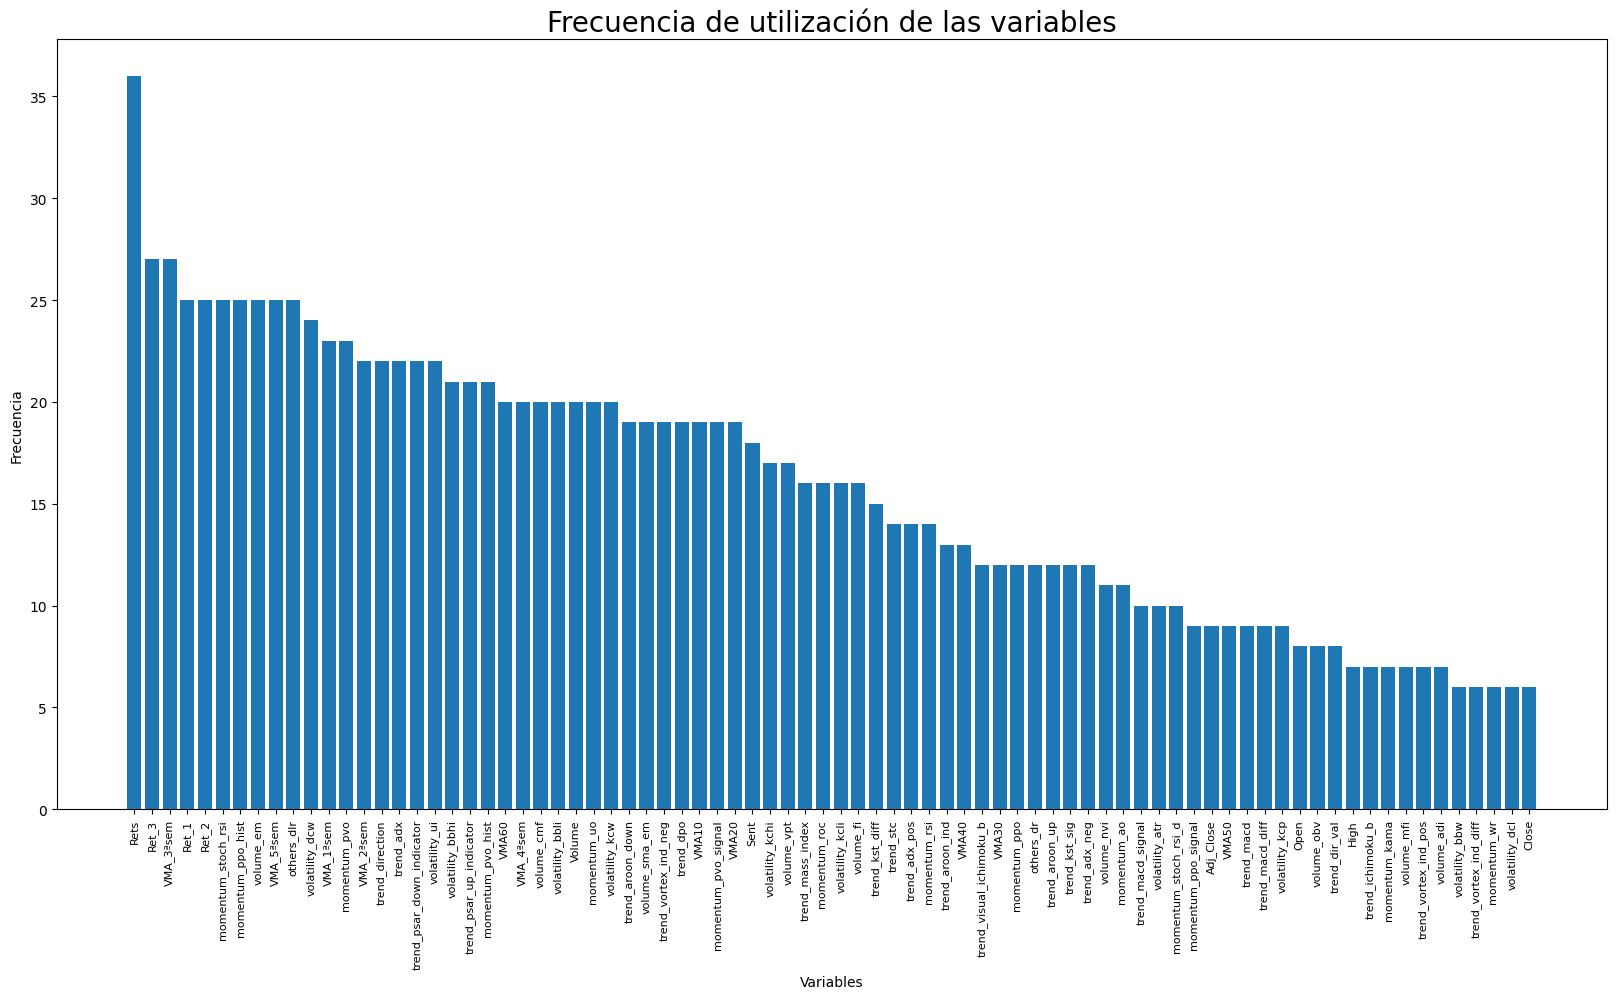

In [11]:
fig, axes = plt.subplots(figsize=(20, 10))
axes.bar(frecuencia_variables.index[:80], height=frecuencia_variables[:80])
axes.tick_params(axis='x', labelsize=8, rotation=90)
axes.set_xlabel('Variables')
axes.set_ylabel('Frecuencia')
axes.set_title('Frecuencia de utilización de las variables', fontsize=20)
plt.show()

#####  LR_F
#####  RF_GOOG
#####  RF_META__
#####  RF_MSFT
#####  LR_TSLA


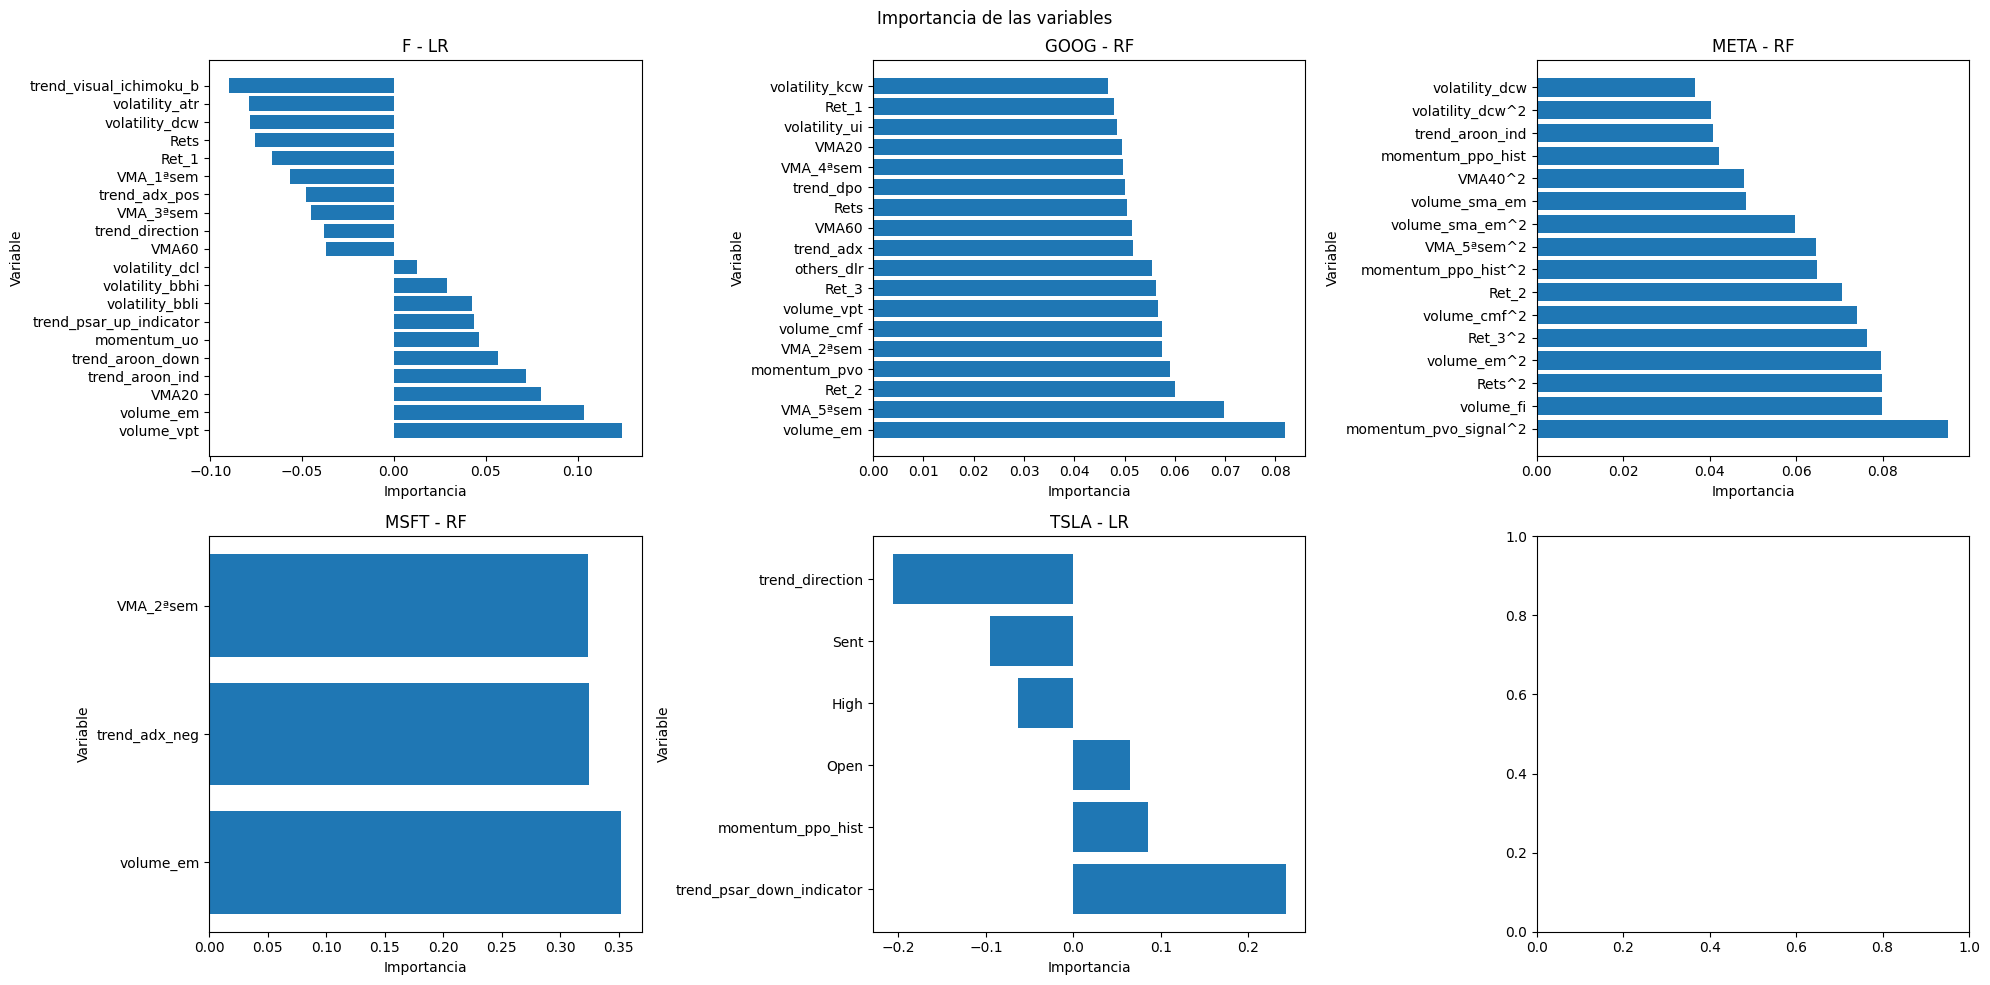

In [12]:
def analasis_importancia_variables(symbol, path, ax):
    data = pd.read_parquet(f'../data/final_{symbol}.parquet').rename(columns={'Adj Close': 'Adj_Close'})
    for archivo in os.listdir(path):
        path_db = f'sqlite:///{path}/{archivo}'
        mlflow.set_tracking_uri(path_db)
        exps = mlflow.search_experiments()
        for e in [e for e in exps if f'_{symbol}' in e.name and e.name != 'Default']:
            if (archivo == 'RF1.db' and symbol in ['GOOG', 'META', 'MSFT']) or (archivo == 'LR1.db' and symbol in ['F', 'TSLA']):
                print('##### ', e.name)
                runs = mlflow.search_runs(e.experiment_id)
                columns_metrics, columns_params, run_name = ([c for c in runs.columns if 'metrics' in c], [c for c in runs.columns if 'params' in c], [c for c in runs.columns if 'runName' in c])
                runs = runs[columns_metrics + columns_params + run_name]
                runs.columns = [c.replace("metrics.", "").replace("params.", "").replace("tags.mlflow.", "") for c in runs.columns]
                runs.sort_values(by='Rendimiento_stock_test', ascending=False, inplace=True)
                best = runs.iloc[0]
                cols = best['Cols'].strip("[]").replace("'", "").replace("\n", "").replace("Adj Close", "Adj_Close").split()
                data_aux = data.copy()
                x_train, x_test, y_train, y_test = preparar_datos(data_aux, eval(best['Remove_corr']), eval(best['Add_feat_sqr']), eval(best['Trans_data']),
                                                                  eval(best['Scaler'] if best['Trans_data'] else 'None'), best['Cols_to_scale'])
                x_train, x_test = x_train.loc[:, cols], x_test.loc[:, cols]
                clf = get_clf(archivo, best)
                clf.fit(x_train, y_train)
                if archivo == 'LR1.db':
                    importancia = clf.coef_[0]
                if archivo == 'RF1.db':
                    importancia = clf.feature_importances_
                importancia_variables = pd.DataFrame({'Variable': x_train.columns, 'Importancia': importancia})
                importancia_variables = importancia_variables.sort_values(by='Importancia', ascending=False)
                ax.barh(importancia_variables['Variable'], importancia_variables['Importancia'])
                ax.set_xlabel('Importancia')
                ax.set_ylabel('Variable')
                ax.set_title(f'{symbol} - {archivo[:-4]}')
                return True
    return False

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
i, j = 0, 0
for s in symbols:
    if analasis_importancia_variables(s, path_dbs, axes[i, j]):
        j += 1
        if j == 3:
            j = 0
            i += 1
fig.suptitle('Importancia de las variables')
plt.tight_layout();
plt.show()